# 3x3 Sensor Array for Water Sensor, Multi file
Author: Jonathan

# Standard step test

## Load

### Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.dates as mdates
from datetime import datetime, timedelta


print(sys.executable)

%matplotlib ipympl

color_array = [
    (0.121, 0.466, 0.705, 1.0),  # Muted blue
    (1.000, 0.498, 0.055, 1.0),  # Muted orange
    (0.172, 0.627, 0.172, 1.0),  # Muted green
    (0.839, 0.153, 0.157, 1.0),  # Muted red
    (0.580, 0.404, 0.741, 1.0),  # Muted purple
    (0.549, 0.337, 0.294, 1.0),  # Muted brown
    (0.890, 0.466, 0.760, 1.0),  # Muted pink
    (0.498, 0.498, 0.498, 1.0),  # Muted gray
    (0.737, 0.741, 0.133, 1.0),  # Muted yellow-green
]


/usr/bin/python3


In [2]:
!ls "/tf/data"

ASM_module  cecilie  ec  karena  lawance  odorMaster  waterSensor  wendy


### Class

In [2]:
class myWaterTest:
  def __init__(self, testingTime, cumTimeOffset=0, liquLabel = 'DI Water', liquConc = '0uL/100mL', testingSequence=[]):
    self.testingTime = testingTime
    self.cumTimeOffset = cumTimeOffset#-10
    self.liquLabel = liquLabel
    self.liquConc = liquConc
    self.csvFile = '/tf/data/waterSensor/aryData/sensor_'+testingTime+'.csv'
    self.sequenceCsvFile = '/tf/data/waterSensor/aryData/pump_sequence_'+testingTime+'.csv'
      
    #Sensor data
    colnames = ['time']+[f'px{i}' for i in range(9)]
    self.df=pd.read_csv(self.csvFile, names=colnames, header=None, skipfooter=1, engine='python')
    
    self.df['datetime'] = pd.to_datetime(self.df['time'], format='%Y-%m-%dT%H:%M:%S%z').dt.tz_localize(None)
    self.df = self.df.set_index(['datetime'])
    self.df = self.df.drop('time', axis=1)
    self.df.asfreq('s', method='ffill')

    #Control data
    self.seq_df=pd.read_csv(self.sequenceCsvFile, usecols=['Time(s)']+[f"Pump {i+1} (rpm)" for i in range(6)])
    seq_cycle = int(pd.read_csv(self.sequenceCsvFile)['Cycle'][0])
    self.seq_df = pd.concat([self.seq_df]*seq_cycle)
    self.seq_df['cumTime'] = self.seq_df['Time(s)'].cumsum(axis = 0)
    self.seq_df = self.seq_df.rename(columns=dict(zip([f"Pump {i+1} (rpm)" for i in range(6)], [f"Pump{i+1}" for i in range(6)])))
    
    self.seq_df = pd.DataFrame(
        data=self.seq_df.values.repeat(2, axis=0),  # Repeat each row twice
        columns=self.seq_df.columns                # Keep the column names
    )
    self.seq_df['cumTime'] = self.seq_df['cumTime'].shift(1).fillna(0)
    self.seq_df.loc[self.seq_df.index[1::2], 'cumTime'] = self.seq_df.loc[self.seq_df.index[1::2], 'cumTime'] - 1
    
    self.seq_df["timestamp"] = self.seq_df["cumTime"].apply(lambda x: self.df.index[0] + timedelta(seconds=x) if x >= 0 else None)
    self.seq_df.set_index("timestamp", inplace=True)
    
    #Set keyframe
    flowRatePt = 20
    self.keyTime = self.seq_df[(self.seq_df.Pump2>0)|(self.seq_df.Pump3>0)|(self.seq_df.Pump4>0)|(self.seq_df.Pump5>0)].index #(seq_df.Pump1==20)|
    self.keyTime = self.keyTime[1::2]
    self.keyTime = self.keyTime[1::2]
    # print(keyTime)

    flowRatePt = 100
    # self.keyTimeBaseline = self.seq_df[(self.seq_df.Pump2==flowRatePt)|(self.seq_df.Pump3==flowRatePt)|(self.seq_df.Pump4==flowRatePt)|(self.seq_df.Pump5==flowRatePt)].index
    # self.keyTimeBaseline = self.seq_df[(self.seq_df.Pump1==100)].index
    # self.keyTimeBaseline = self.keyTimeBaseline[::2]
    # print(keyTimeBaseline)

    self.testingSequence = testingSequence*seq_cycle #uL

### File

In [3]:
myTest = []

testingSequence = [10, 30, 60, 100] #uL:1L
myTest.append(myWaterTest('20250603_125215', liquLabel = 'Acetone', liquConc = '10uL/100mL', testingSequence=testingSequence))
myTest.append(myWaterTest('20250603_172217', liquLabel = 'Benzene', liquConc = '10uL/100mL', testingSequence=testingSequence))
myTest.append(myWaterTest('20250603_202421', liquLabel = 'Toluene', liquConc = '10uL/100mL', testingSequence=testingSequence))
myTest.append(myWaterTest('20250603_232616', liquLabel = 'Formaldehyde', liquConc = '10uL/100mL', testingSequence=testingSequence))

In [401]:
myTest[0].testingSequence

[10, 30, 60, 100, 10, 30, 60, 100]

In [4]:
pltMax = []
pltMin = []

for myTestItem in myTest:
    pltMax.append(myTestItem.df.max().max())
    pltMin.append(myTestItem.df.max().max())
    
pltMax = np.max(pltMax)    
pltMin = np.min(pltMin)
print(pltMax, pltMin)

3084 2884


## Plot raw data

### All plot

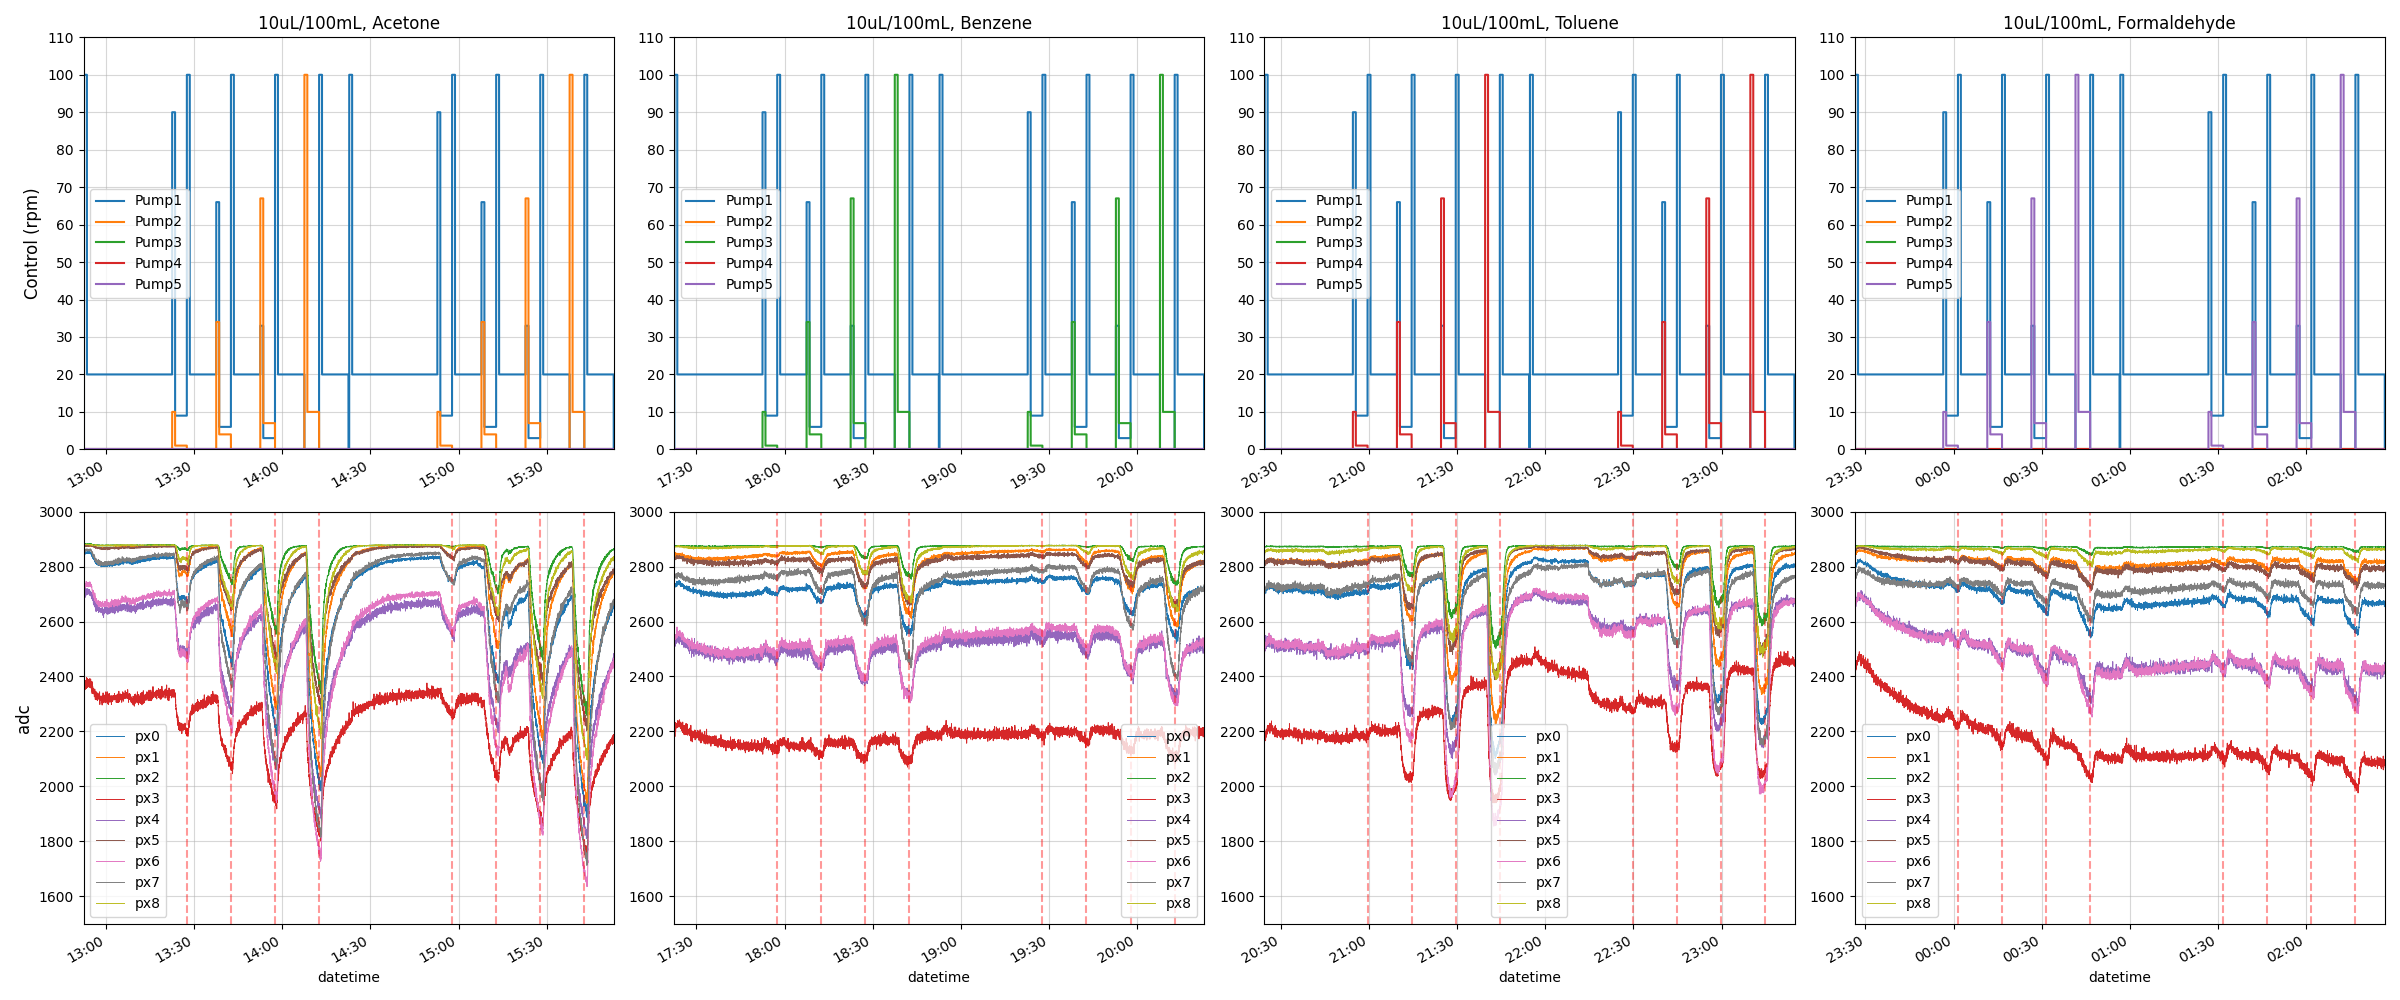

In [5]:
thisTestId = 1
    
plt.close('all')
fig, ax = plt.subplots(nrows=2,ncols=len(myTest), figsize=(24,10))

for thisTestId in range(len(myTest)):
    thisAx=ax[0, thisTestId]
    for i in range(5):
        myTest[thisTestId].seq_df.plot(ax=thisAx, y=f'Pump{i+1}', lw=1.5, alpha=1)
    thisAx.set_title(f'{myTest[thisTestId].liquConc}, {myTest[thisTestId].liquLabel}')
    if thisTestId == 0:
        thisAx.set_ylabel("Control (rpm)",fontsize=12)
    
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    thisAx.yaxis.set_major_locator(MultipleLocator(10))
    thisAx.xaxis.set_major_locator(MultipleLocator(6/(12*24)))
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlabel('')
    thisAx.set_ylim([0, 110])
    thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    thisAx=ax[1, thisTestId]
    for i in range(9):
        myTest[thisTestId].df.plot(ax=thisAx, y=f'px{i}', lw=0.7, color = color_array[i]) #, alpha = (i+1)/9, color='black'
    
    for time in myTest[thisTestId].keyTime:
        thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.4)
        
    # for time in myTest[thisTestId].keyTimeBaseline:
    #     thisAx.axvline(x=time, color='blue', linestyle='--', alpha=0.2)
    if thisTestId == 0:
        thisAx.set_ylabel("adc",fontsize=12)
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    thisAx.yaxis.set_major_locator(MultipleLocator(200))
    thisAx.xaxis.set_major_locator(MultipleLocator(6/(12*24)))
    # thisAx.set_ylim([myTest[thisTestId].df[[f'px{i}' for i in range(9)]].min().min(), myTest[thisTestId].df[[f'px{i}' for i in range(9)]].max().max()])
    thisAx.set_ylim([1500, 3000])
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()



### Single plot

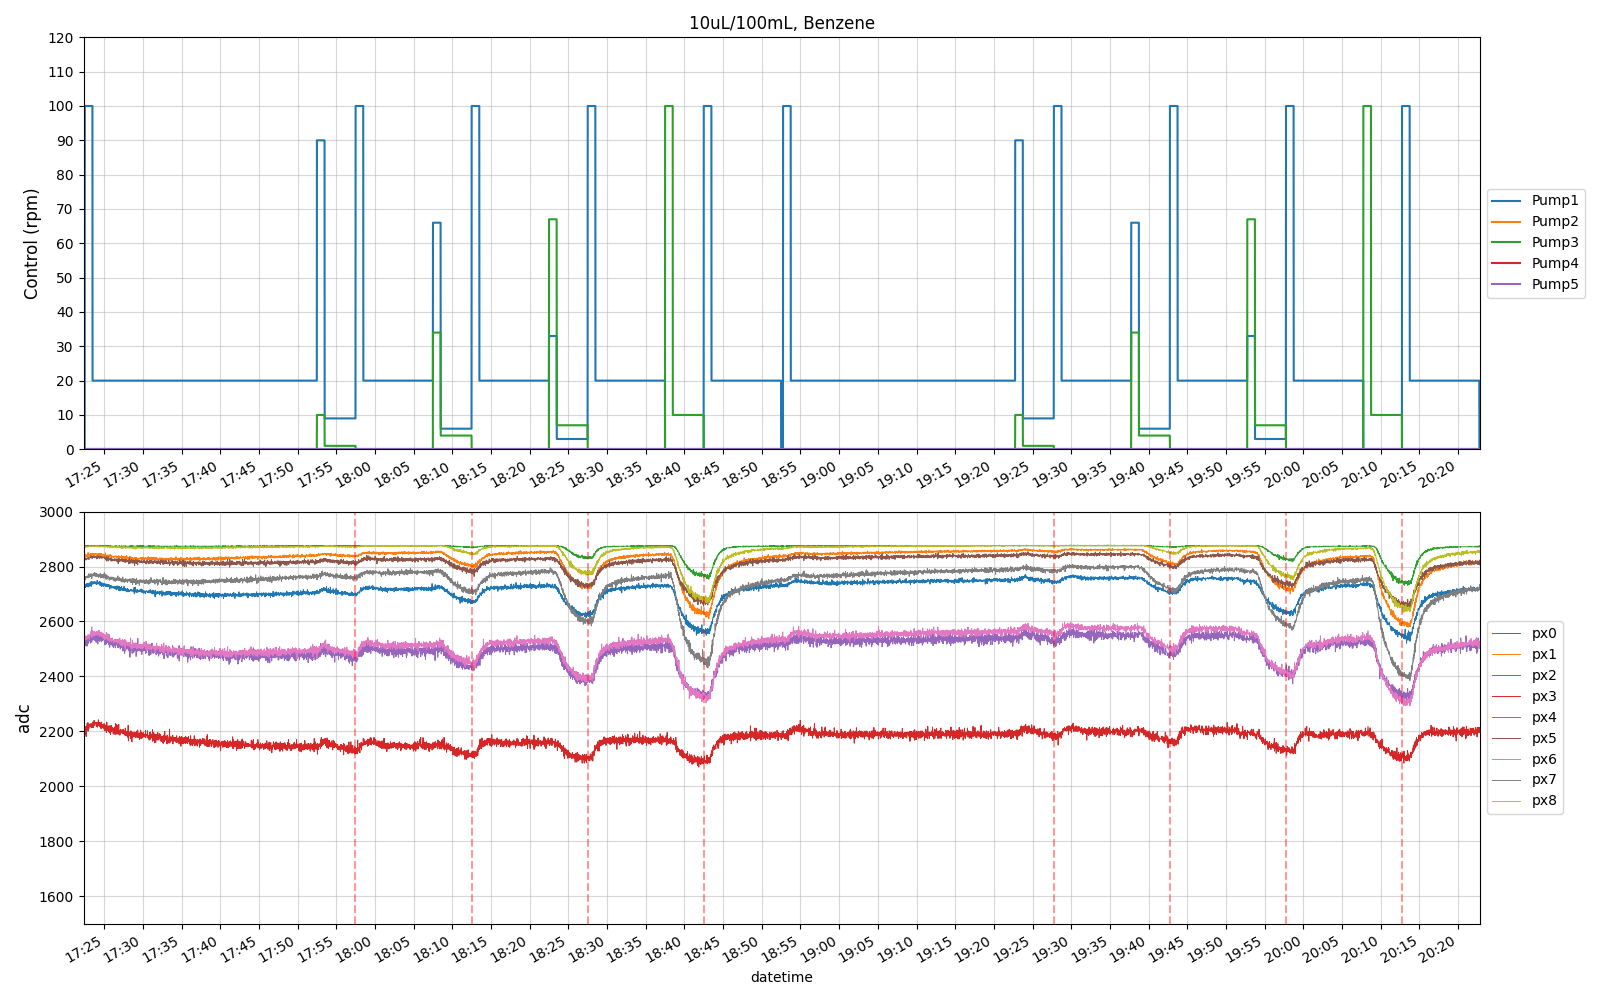

In [6]:
thisTestId = 1

plt.close('all')
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(16,10))

thisAx=ax[0]
for i in range(5):
    myTest[thisTestId].seq_df.plot(ax=thisAx, y=f'Pump{i+1}', lw=1.5, alpha=1)
thisAx.set_title(f'{myTest[thisTestId].liquConc}, {myTest[thisTestId].liquLabel}')

thisAx.set_ylabel("Control (rpm)",fontsize=12)

thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.yaxis.set_major_locator(MultipleLocator(10))
thisAx.xaxis.set_major_locator(MultipleLocator(1/(12*24)))
thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
thisAx.set_xlabel('')
thisAx.set_ylim([0, 120])
thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

thisAx=ax[1]
for i in range(9):
    myTest[thisTestId].df.plot(ax=thisAx, y=f'px{i}', lw=0.7, color = color_array[i]) #, alpha = (i+1)/9, color='black'

for time in myTest[thisTestId].keyTime:
    thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.4)
    
# for time in myTest[thisTestId].keyTimeBaseline:
#     thisAx.axvline(x=time, color='blue', linestyle='--', alpha=0.2)
    
thisAx.set_ylabel("adc",fontsize=12)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.yaxis.set_major_locator(MultipleLocator(200))
thisAx.xaxis.set_major_locator(MultipleLocator(1/(12*24)))
# thisAx.set_ylim([myTest[thisTestId].df[[f'px{i}' for i in range(9)]].min().min(), myTest[thisTestId].df[[f'px{i}' for i in range(9)]].max().max()])
thisAx.set_ylim([1500, 3000])
thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()



### Save plot to svg

In [59]:
#f'exportSvg/raw_{myTest[thisTestId].testingTime}_{myTest[thisTestId].liquLabel}.svg'
plt.savefig(f'exportSvg/raw_{myTest[thisTestId].testingTime}_{myTest[thisTestId].liquLabel}.svg', bbox_inches='tight', pad_inches = 0)

'exportSvg/raw_20250603_125215_Acetone.svg'

## Calibration

### Baseline correction

In [540]:
myTest[1].df.var0

datetime
2025-06-03 17:22:20    1.000000
2025-06-03 17:22:24    1.000000
2025-06-03 17:22:25    1.000000
2025-06-03 17:22:26    1.000000
2025-06-03 17:22:27    1.000000
                         ...   
2025-06-03 20:24:10    0.006378
2025-06-03 20:24:11    0.006375
2025-06-03 20:24:14    0.006372
2025-06-03 20:24:15    0.006369
2025-06-03 20:24:16    0.006367
Name: var0, Length: 9227, dtype: float64

In [90]:
#Tuning 
window_size = [15, 15, 15, 
               10, 5, 15, 
               15, 15, 15]
tracking_rate = [1, 1, 1, 1]
# Function to calculate updated mu and var
# def update_mu_var(window, prior_mu, prior_var):
#     likelihood_mu = window.mean()
#     likelihood_var = np.max((window.var(), 0.001))
#     baselineMode = 1
#     # Update using provided formula
#     updated_mu = (likelihood_mu * prior_var + prior_mu * likelihood_var) / (prior_var + likelihood_var)
#     if window.iloc[-1] > updated_mu: # Signal lower than Baseline
#         updated_var = (1/(tracking_rate[0]*likelihood_var) + 1/(tracking_rate[1]*prior_var))**(-1)
#         baselineMode = -1
#     else:
#         updated_var = (1/(tracking_rate[2]*likelihood_var) + 1/(tracking_rate[3]*prior_var))**(-1)
#         updated_mu = likelihood_mu
#     return updated_mu, updated_var, baselineMode

def update_mu_var(window, prior_mu, prior_var):
    likelihood_mu = window.mean()
    likelihood_var = np.max((window.var(), 0.001)) #boundary limitations
    baselineMode = 1
    # Update using provided formula
    updated_var = (1/(likelihood_var) + 1/(prior_var))**(-1)
    updated_mu = (likelihood_mu * prior_var + prior_mu * likelihood_var) / (prior_var + likelihood_var)
    if likelihood_mu > prior_mu: # Signal lower than Baseline
        updated_mu = likelihood_mu
        baselineMode = -1
    # else:
    #     updated_mu = (likelihood_mu * prior_var + prior_mu * likelihood_var) / (prior_var + likelihood_var)

    return updated_mu, updated_var, baselineMode
    
#for thisTest in myTest:
thisTest = myTest[0]
if 1:
    print(thisTest.liquLabel, end='  ')
    for i in range(9):
        thisTest.df[f'mu{i}'] = thisTest.df[f'px{i}'].iloc[0:3].median() #float(df[f'px{i}'].iloc[0])
        thisTest.df[f'var{i}'] = float(1)
        thisTest.df[f'baselineMode{i}'] = 1

    pxId = 4
    if 1:
    #for pxId in range(9):
        
        for i in range(window_size[pxId] - 1, len(thisTest.df)):
            # Current rolling window using .iloc
            window = thisTest.df.iloc[i - window_size[pxId] + 1:i + 1, pxId]  # Slice only the 'px0' column values
            
            if i == window_size[pxId] - 1:  # Initial prior values for the first window
                prior_mu, prior_var = window.mean(), window.var()
            else:  # Use the previous row's mu and var as the prior
                prior_mu = thisTest.df.iloc[i - 1][f'mu{pxId}']
                prior_var = thisTest.df.iloc[i - 1][f'var{pxId}']
            
            # Update mu and var
            updated_mu, updated_var, baselineMode = update_mu_var(window, prior_mu, prior_var)
            
            # Assign the results to the DataFrame
            thisTest.df.iloc[i, thisTest.df.columns.get_loc(f'mu{pxId}')] = updated_mu
            thisTest.df.iloc[i, thisTest.df.columns.get_loc(f'var{pxId}')] = updated_var
            thisTest.df.iloc[i, thisTest.df.columns.get_loc(f'baselineMode{pxId}')] = baselineMode
        
        print(pxId, end=' ')
        thisTest.df[f'resp{pxId}'] = thisTest.df[f'mu{pxId}']-thisTest.df[f'px{pxId}']
        # df[f'resp{pxId}'] = df[f'resp{pxId}'].rolling(window_size[pxId]).sum()
        thisTest.df[f'px{pxId}_rollingMu'] = thisTest.df[f'px{pxId}'].rolling(window_size[pxId]).mean()
    print()

Acetone  4 


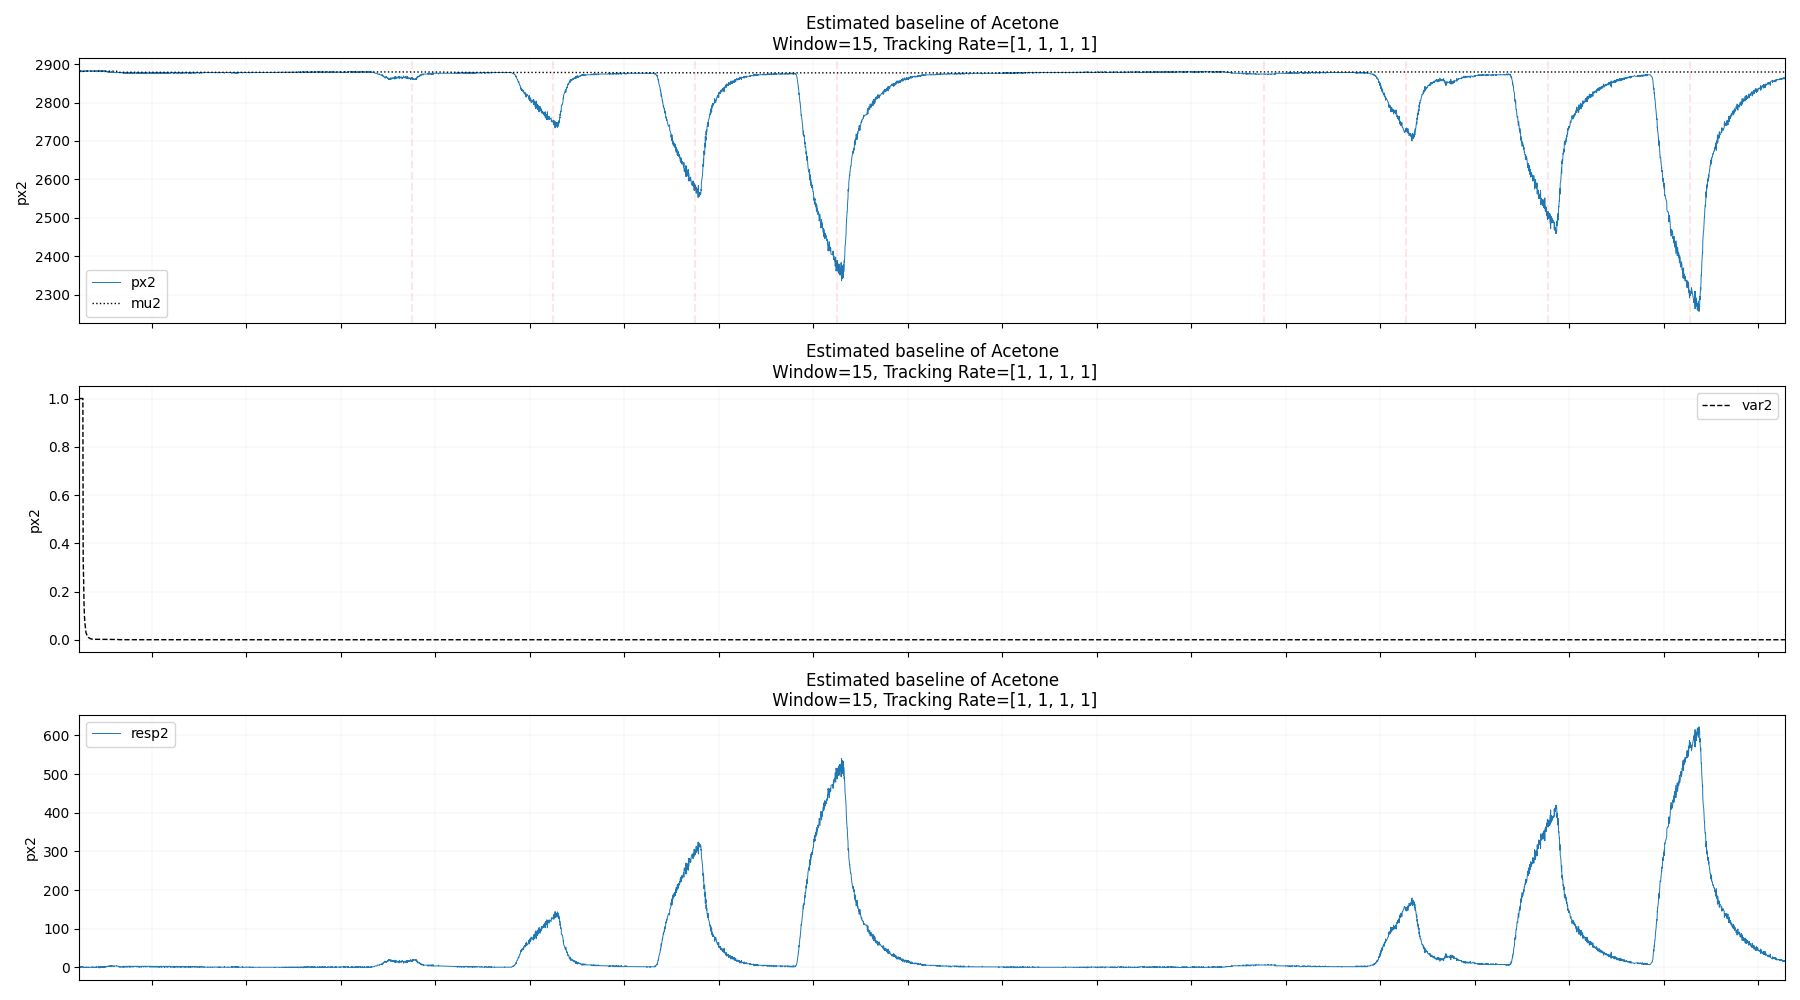

In [79]:
pxId=2
thisTest = myTest[0]
plt.close('all')
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(18,10))

thisAx=ax[0]

thisTest.df.plot(ax=thisAx, y=f'px{pxId}', lw=0.7,color=color_array[i]) #, alpha = (i+1)/9, color='black'
thisTest.df.plot(ax=thisAx, y=f'mu{pxId}', lw=1,color='black', linestyle=':')
for time in thisTest.keyTime:
    thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.1)
    
thisAx=ax[1]
# thisTest.df.plot(ax=thisAx, y=f'baselineMode{i}', lw=1,color='black', linestyle='--')
thisTest.df.plot(ax=thisAx, y=f'var{pxId}', lw=1,color='black', linestyle='--')

thisAx=ax[2]
thisTest.df.plot(ax=thisAx, y=f'resp{pxId}', lw=0.7,color=color_array[i])


for thisAx in ax:
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    
    thisAx.xaxis.set_major_locator(MultipleLocator(2/(12*24)))
    # thisAx.set_ylim([df[[f'px{i}' for i in range(9)]].min().min(), df[[f'px{i}' for i in range(9)]].max().max()])
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlim(thisTest.seq_df.index.min(), thisTest.seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i == 0:
        thisAx.set_title(f'Estimated baseline of {thisTest.liquLabel}\n Window={window_size}, Tracking Rate={tracking_rate}')
    if i<8:
        thisAx.set_xlabel('')
        thisAx.set_xticklabels([])
    thisAx.grid(True, which='both', color='gray', linewidth=0.1)
    thisAx.set_ylabel(f'px{pxId}')

    
fig.tight_layout()

#### Plot Baseline & Signal

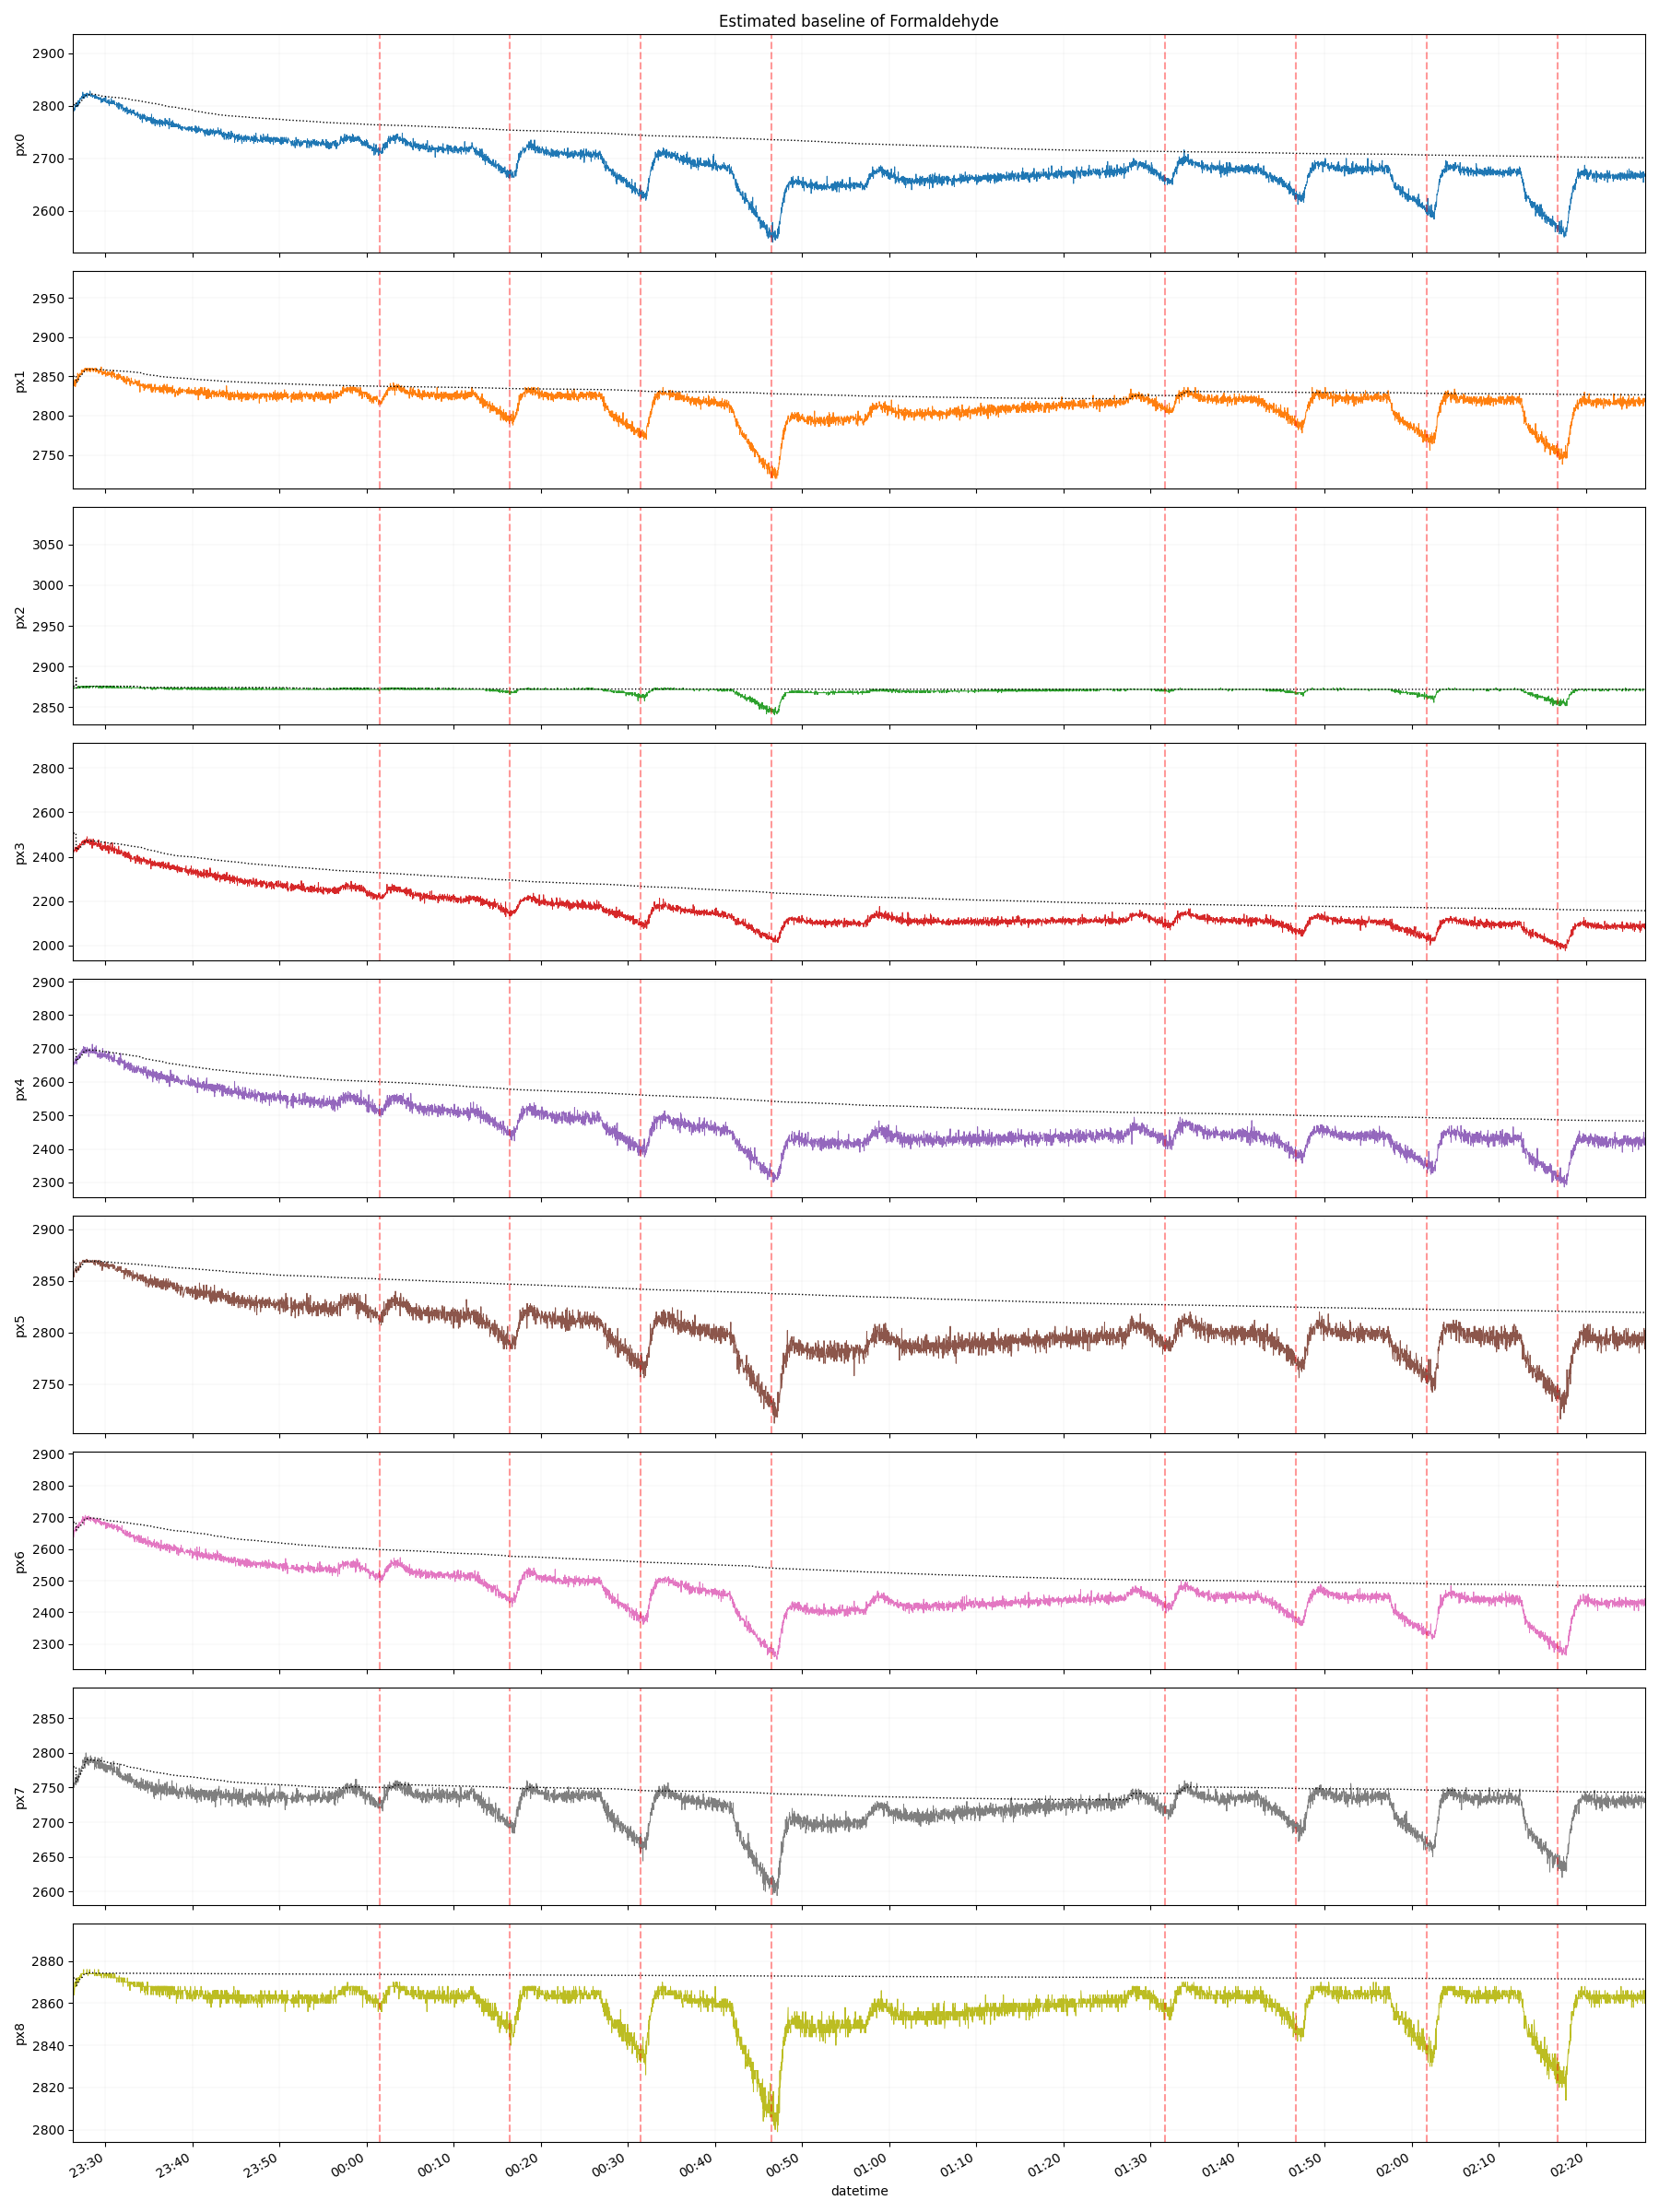

In [170]:
thisTest = myTest[3]

plt.close('all')
fig, ax = plt.subplots(nrows=9,ncols=1, figsize=(18,24))

thisAx=ax[0]

for i in range(9):
    thisAx=ax[i]
    thisTest.df.plot(ax=thisAx, y=f'px{i}', lw=0.7,color=color_array[i]) #, alpha = (i+1)/9, color='black'
    thisTest.df.plot(ax=thisAx, y=f'mu{i}', lw=1,color='black', linestyle=':')
    for time in thisTest.keyTime:
        thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.4)
        
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    # thisAx.yaxis.set_major_locator(MultipleLocator(100))
    thisAx.xaxis.set_major_locator(MultipleLocator(2/(12*24)))
    # thisAx.set_ylim([df[[f'px{i}' for i in range(9)]].min().min(), df[[f'px{i}' for i in range(9)]].max().max()])
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlim(thisTest.seq_df.index.min(), thisTest.seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i == 0:
        # thisAx.set_title(f'Estimated baseline of {thisTest.liquLabel}\n Window={window_size}, Tracking Rate={tracking_rate}')
        thisAx.set_title(f'Estimated baseline of {thisTest.liquLabel}')
    if i<8:
        thisAx.set_xlabel('')
        thisAx.set_xticklabels([])
    thisAx.grid(True, which='both', color='gray', linewidth=0.1)
    thisAx.set_ylabel(f'px{i}')
    thisAx.legend().set_visible(False)
    # thisAx=thisAx.twinx()
    # thisTest.df.plot(ax=thisAx, y=f'baselineMode{i}', lw=1,color='black', linestyle='--')
    
fig.tight_layout()

#### Plot Response

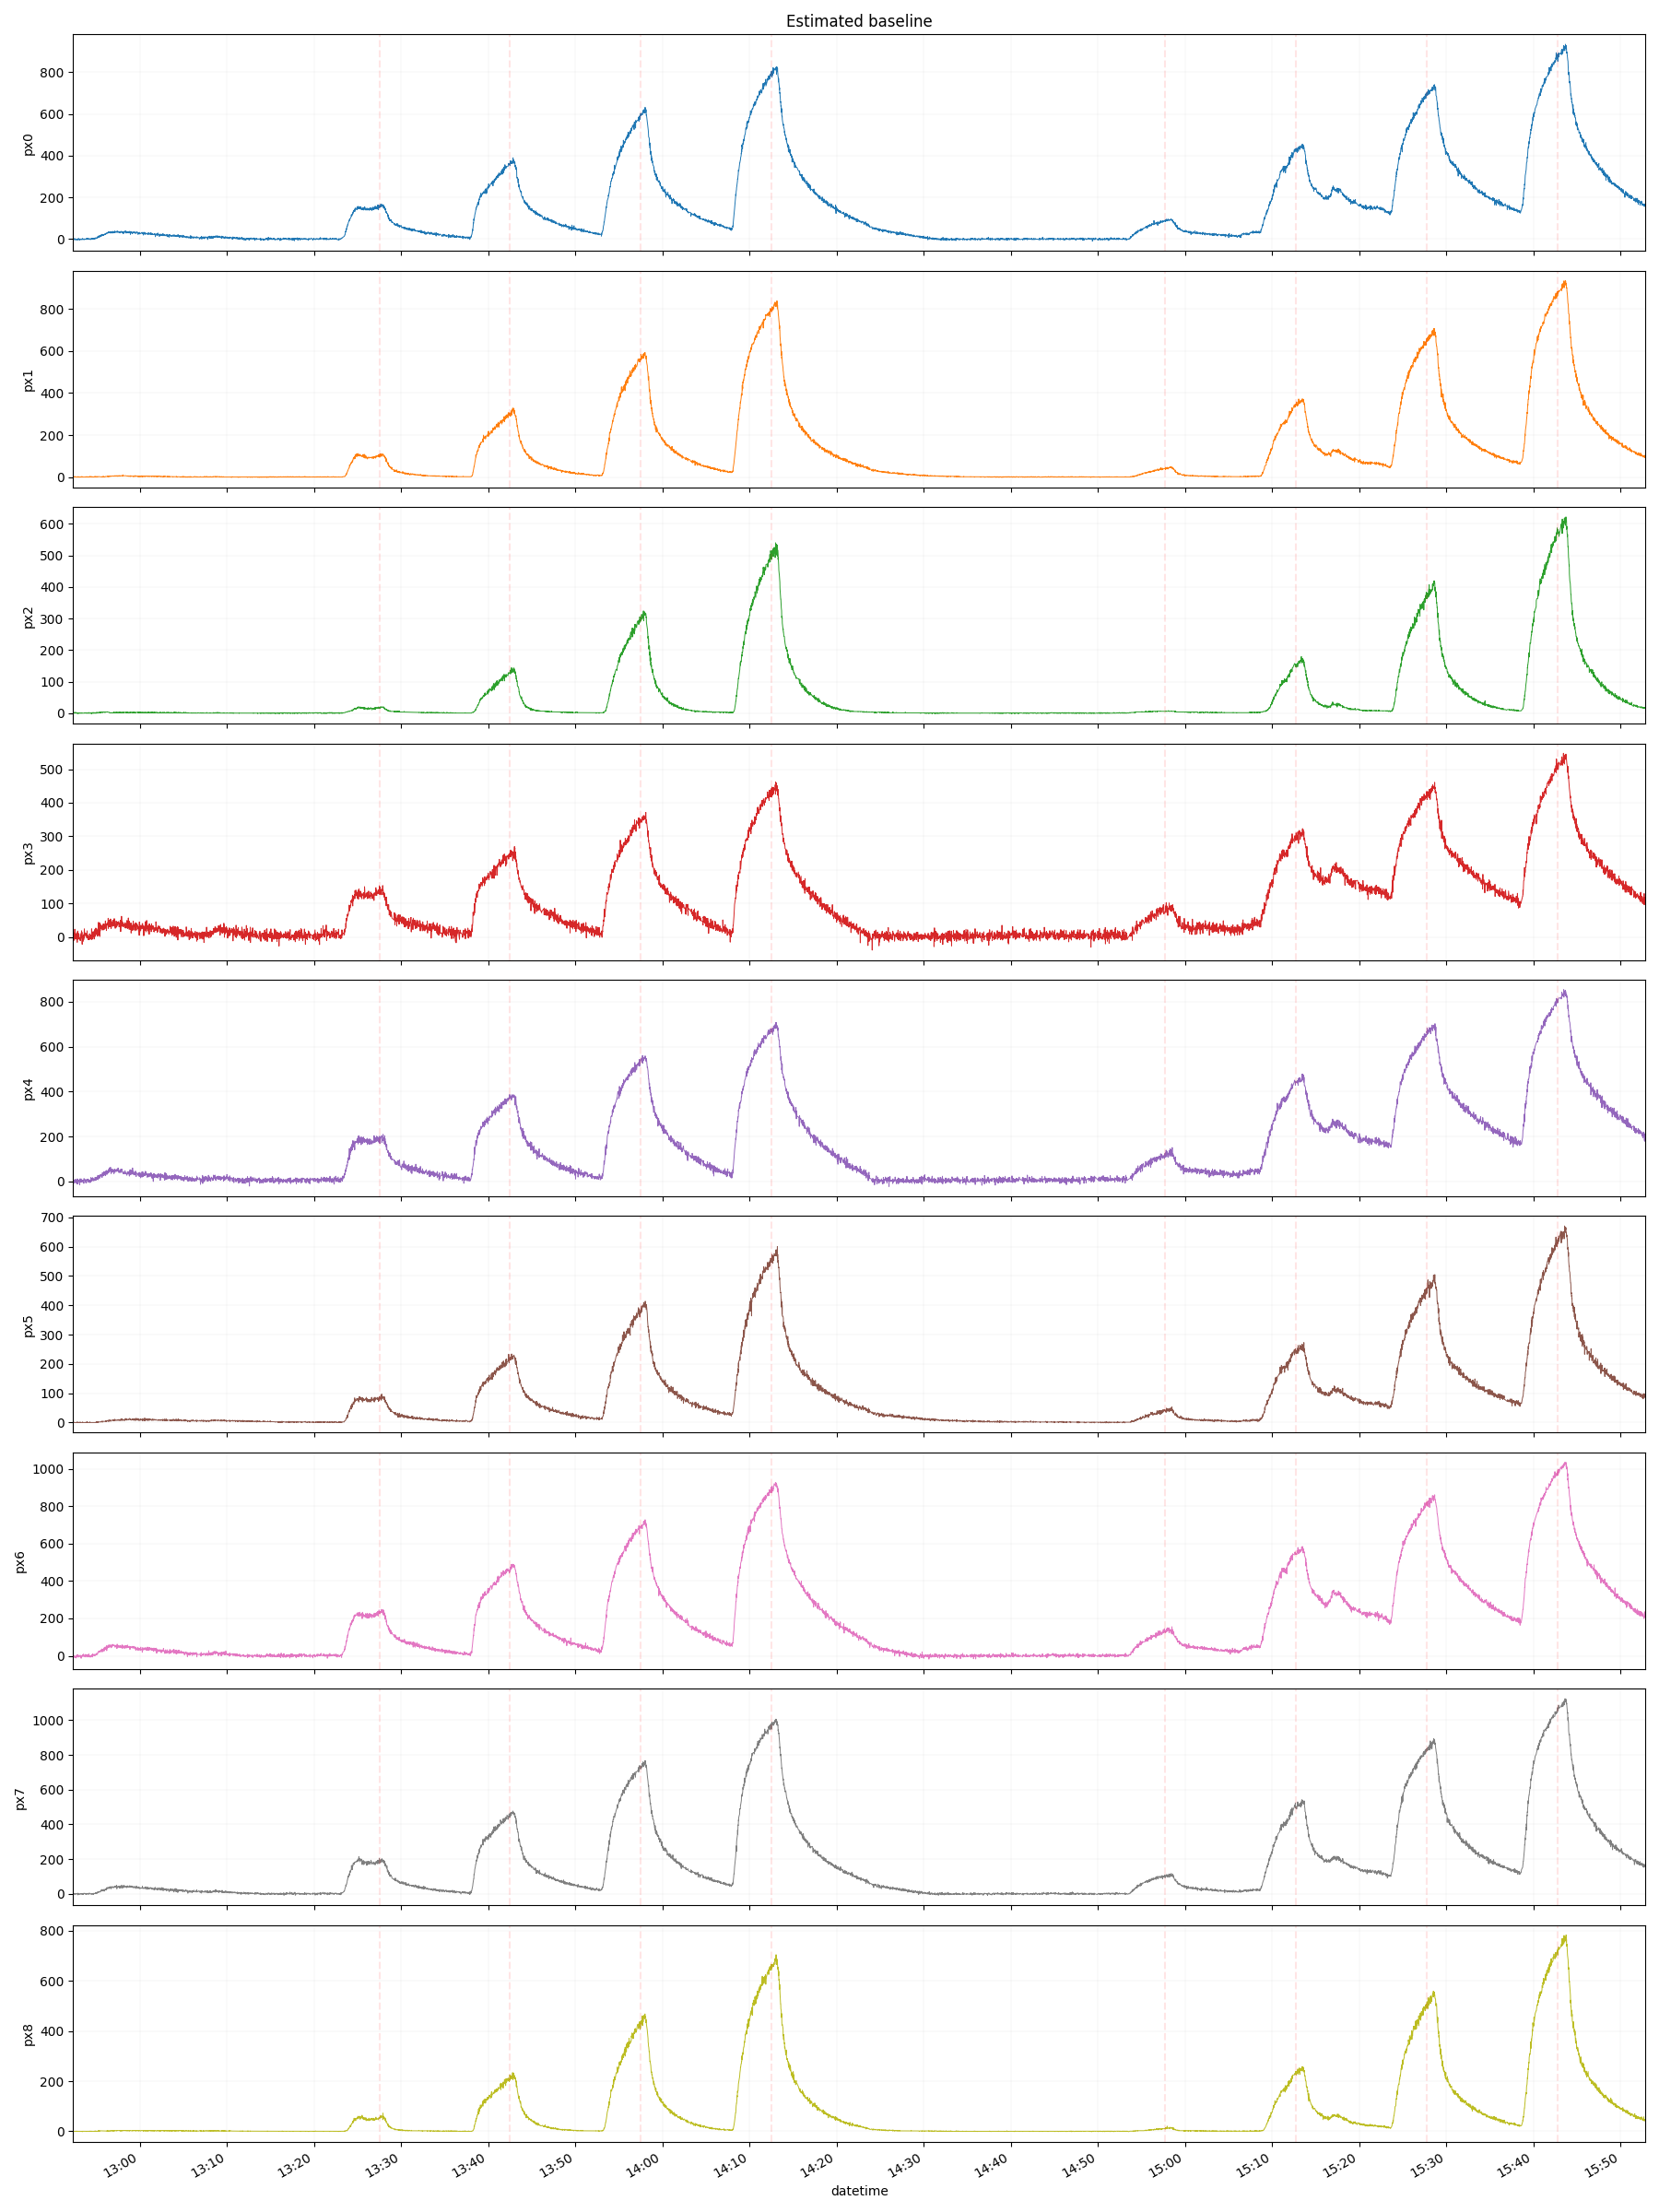

In [165]:
plt.close('all')
fig, ax = plt.subplots(nrows=9,ncols=1, figsize=(18,24))

thisAx=ax[0]

for i in range(9):
    thisAx=ax[i]
    thisTest.df.plot(ax=thisAx, y=f'resp{i}', lw=0.7,color=color_array[i]) #, alpha = (i+1)/9, color='black'
    # thisTest.df.plot(ax=thisAx, y=f'mu{i}', lw=1,color='black', linestyle=':')
    for time in thisTest.keyTime:
        thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.1)
        
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    # thisAx.yaxis.set_major_locator(MultipleLocator(100))
    thisAx.xaxis.set_major_locator(MultipleLocator(2/(12*24)))
    # thisAx.set_ylim([df[[f'px{i}' for i in range(9)]].min().min(), df[[f'px{i}' for i in range(9)]].max().max()])
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlim(thisTest.seq_df.index.min(), thisTest.seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i == 0:
        # thisAx.set_title(f'Estimated baseline of {thisTest.liquLabel}\n Window={window_size}, Tracking Rate={tracking_rate}')
        thisAx.set_title(f'Estimated baseline')
    if i<8:
        thisAx.set_xlabel('')
        thisAx.set_xticklabels([])
    thisAx.grid(True, which='both', color='gray', linewidth=0.1)
    thisAx.set_ylabel(f'px{i}')
    thisAx.legend().set_visible(False)
    # thisAx=thisAx.twinx()
    # thisTest.df.plot(ax=thisAx, y=f'baselineMode{i}', lw=1,color='black', linestyle='--')
    
fig.tight_layout()

np.float64(279.77298476457236)

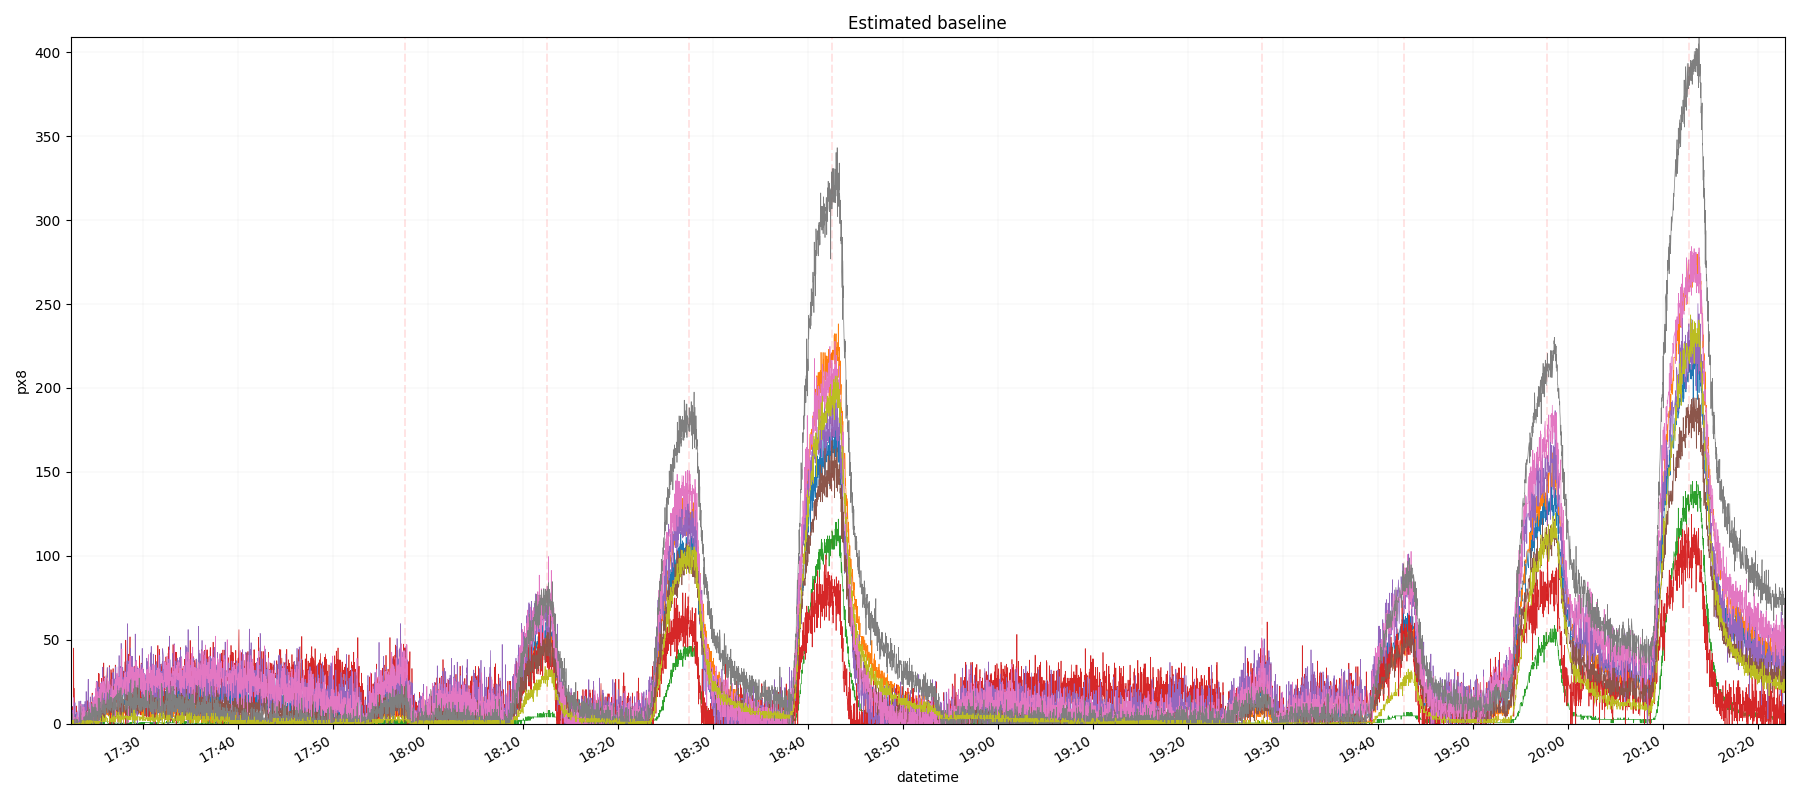

In [71]:
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,8))
yLimMax = thisTest.df[[f'resp{i}' for i in range(9)]].max().max()
for i in range(9):
    thisAx=ax
    thisTest.df.plot(ax=thisAx, y=f'resp{i}', lw=0.5,color=color_array[i]) #, alpha = (i+1)/9, color='black'
    # thisTest.df.plot(ax=thisAx, y=f'mu{i}', lw=1,color='black', linestyle=':')
    for time in thisTest.keyTime:
        thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.01)
        
    # for time in keyTimeBaseline:
    #     thisAx.axvline(x=time, color='blue', linestyle='--', alpha=0.1)
    thisAx.set_ylim([0, yLimMax])
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    # thisAx.yaxis.set_major_locator(MultipleLocator(100))
    thisAx.xaxis.set_major_locator(MultipleLocator(2/(12*24)))
    # thisAx.set_ylim([df[[f'px{i}' for i in range(9)]].min().min(), df[[f'px{i}' for i in range(9)]].max().max()])
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlim(thisTest.seq_df.index.min(), thisTest.seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i == 0:
        # thisAx.set_title(f'Estimated baseline of {thisTest.liquLabel}\n Window={window_size}, Tracking Rate={tracking_rate}')
        thisAx.set_title(f'Estimated baseline')
    if i<8:
        thisAx.set_xlabel('')
        thisAx.set_xticklabels([])
    thisAx.grid(True, which='both', color='gray', linewidth=0.1)
    thisAx.set_ylabel(f'px{i}')
    thisAx.legend().set_visible(False)
    # thisAx=thisAx.twinx()
    # thisTest.df.plot(ax=thisAx, y=f'baselineMode{i}', lw=1,color='black', linestyle='--')
    
fig.tight_layout()

### Get Keyframe & Plot Matrix

In [171]:
import pandas as pd

# Initialize an empty list to store subframes
all_subframes = []

# Loop over all myTest objects
for thisTestId, test in enumerate(myTest):
    # Sort the DataFrame by its index
    df = test.df.sort_index()
    
    # Create a DataFrame from keyTime
    key_time_df = pd.DataFrame({'timestamp': test.keyTime})
    
    # Perform an asof merge to get the nearest matches
    subframe = pd.merge_asof(key_time_df, df, left_on='timestamp', right_index=True)
    
    # Add a column to indicate the test ID
    subframe['yy'] = thisTestId
    #print(test.testingSequence)
    subframe['conc'] = test.testingSequence
    # Append the processed subframe to the list
    all_subframes.append(subframe)

# Concatenate all subframes into a single DataFrame
key_df = pd.concat(all_subframes, ignore_index=True)
key_df

timestamp   px0   px1   px2   px3   px4   px5   px6   px7   px8  \
0  2025-06-03 13:27:30  2678  2774  2864  2184  2481  2786  2468  2638  2824   
1  2025-06-03 13:42:30  2472  2569  2748  2067  2274  2652  2221  2392  2668   
2  2025-06-03 13:57:30  2218  2314  2584  1943  2092  2498  1977  2094  2468   
3  2025-06-03 14:12:30  2007  2081  2386  1823  1926  2328  1760  1855  2236   
4  2025-06-03 14:57:45  2742  2834  2874  2254  2562  2837  2572  2749  2868   
5  2025-06-03 15:12:45  2410  2528  2724  2029  2234  2638  2154  2346  2652   
6  2025-06-03 15:27:45  2130  2214  2509  1884  2018  2414  1862  2005  2372   
7  2025-06-03 15:42:45  1938  1992  2310  1798  1870  2258  1698  1793  2166   
8  2025-06-03 17:57:29  2700  2838  2874  2138  2455  2824  2478  2758  2872   
9  2025-06-03 18:12:29  2670  2802  2870  2116  2434  2788  2440  2704  2850   
10 2025-06-03 18:27:29  2634  2730  2830  2105  2392  2732  2404  2604  2772   
11 2025-06-03 18:42:29  2568  2632  2761  2084  2326  2656  2316  2468  2684   
12 2025-06-03 19:27:44  2744  2856  2876  2182  2542  2831  2530  2788  2876   
13 2025-06-03 19:42:44  2710  2812  2872  2164  2486  2798  2497  2722  2852   
14 2025-06-03 19:57:44  2641  2720  2830  2137  2416  2740  2416  2597  2769   
15 2025-06-03 20:12:44  2546  2593  2749  2116  2340  2671  2320  2404  2662   
16 2025-06-03 20:59:32  2704  2816  2874  2180  2490  2810  2514  2728  2858   
17 2025-06-03 21:14:32  2442  2604  2768  2044  2272  2664  2196  2464  2714   
18 2025-06-03 21:29:32  2266  2402  2652  1992  2165  2537  2028  2239  2558   
19 2025-06-03 21:44:32  2168  2280  2552  1982  2096  2447  1914  2094  2442   
20 2025-06-03 22:29:47  2730  2828  2874  2284  2562  2836  2550  2738  2862   
21 2025-06-03 22:44:47  2535  2652  2808  2140  2368  2703  2285  2520  2750   
22 2025-06-03 22:59:47  2328  2474  2676  2082  2242  2578  2080  2284  2600   
23 2025-06-03 23:14:47  2255  2360  2624  2062  2188  2534  2016  2176  2508   
24 2025-06-04 00:01:27  2710  2820  2872  2220  2532  2816  2538  2730  2860   
25 2025-06-04 00:16:27  2678  2796  2870  2158  2450  2792  2442  2692  2848   
26 2025-06-04 00:31:27  2632  2776  2864  2106  2408  2770  2388  2656  2832   
27 2025-06-04 00:46:27  2556  2721  2846  2042  2330  2738  2276  2612  2812   
28 2025-06-04 01:31:42  2657  2806  2870  2084  2418  2784  2410  2713  2856   
29 2025-06-04 01:46:42  2632  2790  2868  2050  2362  2772  2374  2692  2845   
30 2025-06-04 02:01:42  2594  2770  2864  2033  2352  2764  2336  2670  2836   
31 2025-06-04 02:16:42  2568  2750  2856  2002  2310  2738  2290  2636  2824   

    ...       resp5  px5_rollingMu       resp6  px6_rollingMu        resp7  \
0   ...   88.005973    2793.733333  231.080368    2470.000000   204.469082   
1   ...  221.952471    2663.800000  463.581331    2230.600000   442.899897   
2   ...  375.899871    2496.466667  692.496970    1984.200000   733.389524   
3   ...  545.856269    2328.666667  896.374016    1778.266667   965.192882   
4   ...   35.962819    2834.600000  130.203453    2574.733333    99.464578   
5   ...  234.935405    2635.066667  542.237622    2157.000000   499.669247   
6   ...  458.901785    2430.133333  823.203885    1879.466667   835.873704   
7   ...  614.874258    2268.733333  975.725180    1704.800000  1043.542137   
8   ...    1.231657    2811.866667   37.393101    2483.200000    15.232074   
9   ...   40.342867    2784.333333   81.887842    2448.666667    78.063537   
10  ...   95.970126    2731.266667  126.697608    2392.266667   178.154556   
11  ...  168.661545    2674.400000  216.383455    2326.533333   306.760251   
12  ...   16.556757    2837.666667   51.108144    2555.400000     9.704307   
13  ...   49.452510    2802.666667   87.930493    2502.733333    78.957742   
14  ...  106.016244    2739.066667  166.085292    2415.000000   201.541663   
15  ...  173.234377    2664.400000  257.423630    2314.466667   391.295845   
16  ...    6.933983    2812.000000   -0.604052

#### plot frame

In [290]:
key_df.iloc[0][[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64)

array([2678, 2774, 2864, 2184, 2481, 2786, 2468, 2638, 2824])

In [292]:
gasMat = np.reshape(key_df.iloc[0][[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64), (-1,3)).astype(int)
gasMat

array([[2678, 2774, 2864],
       [2184, 2481, 2786],
       [2468, 2638, 2824]])

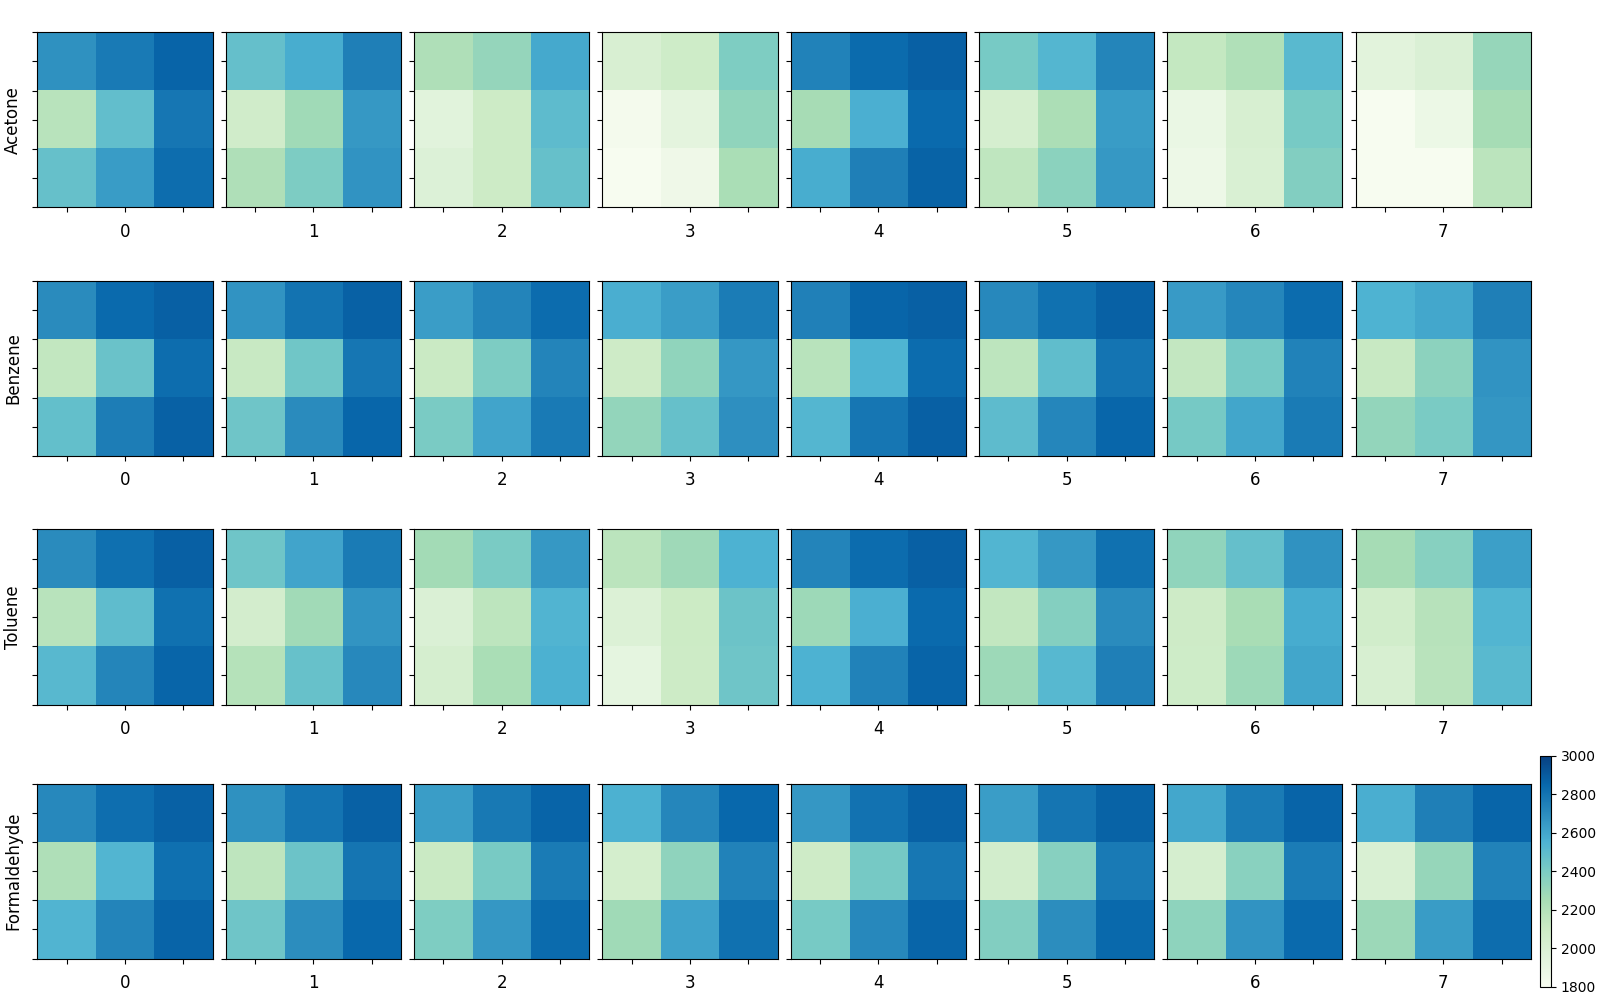

In [382]:
plt.close('all')
fig, ax = plt.subplots(
    ncols=key_df['yy'].value_counts()[0],
    nrows=key_df['yy'].max() + 1,
    figsize=(16, 10),
    constrained_layout=True
)

# Iterate through rows of the DataFrame and create subplots
for index, row in key_df.iterrows():
    thisAx = ax[row['yy'], index % 8]
    gasMat = np.reshape(
        row[[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64),
        (-1, 3)
    ).astype(int)
    im = thisAx.imshow(gasMat, cmap='GnBu', vmin=1800, vmax=3000, interpolation='nearest')

    if index % 8 == 0:
        thisAx.set_ylabel(myTest[row['yy']].liquLabel, fontsize=12)
    thisAx.set_xlabel(index % 8, fontsize=12)

# Remove tick labels from all subplots
for rowAx in ax:
    for thisAx in rowAx:
        thisAx.set_yticklabels([])
        thisAx.set_xticklabels([])

# fig.subplots_adjust(right=0.88) 

# cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # Position for the color bar
# fig.colorbar(im, cax=cbar_ax)  # Use the last `imshow` reference for the colorbar
fig.colorbar(im) 

#### Plot ADC Matrix

/tmp/ipykernel_6686/2341077148.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


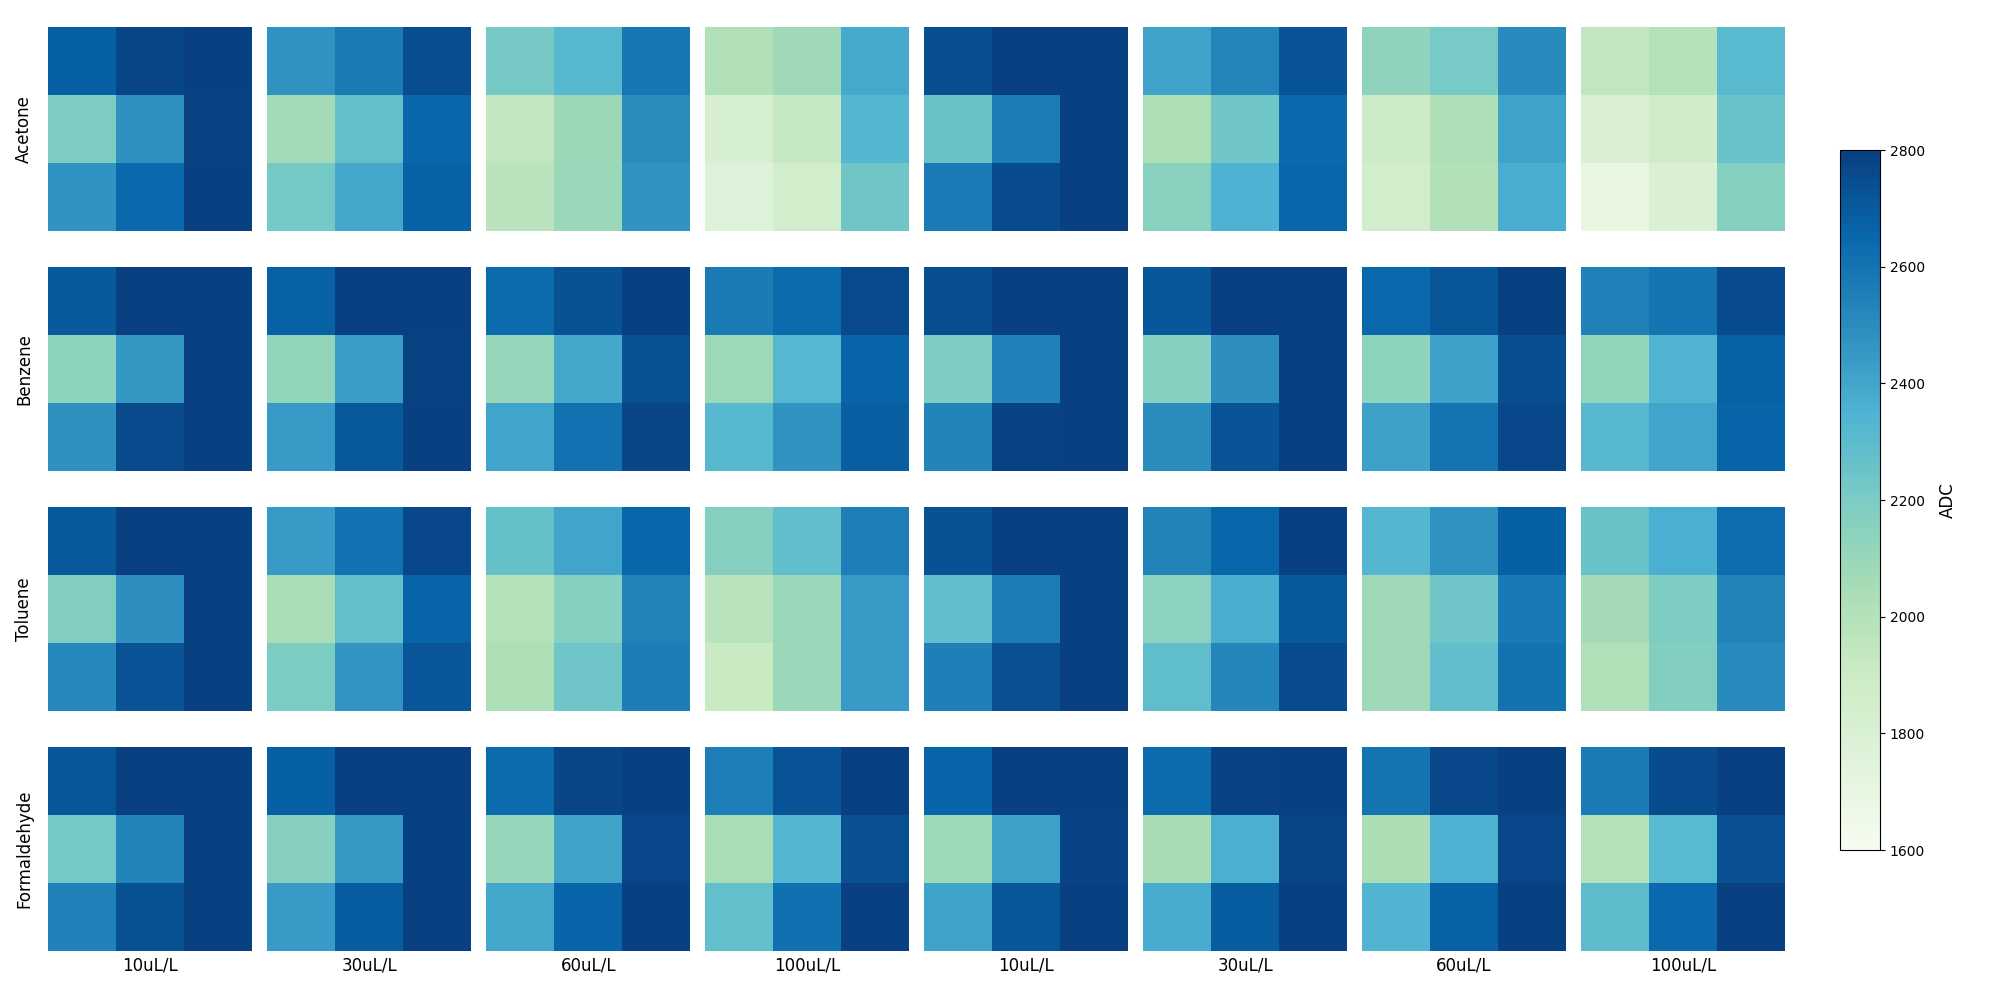

In [131]:

plt.close('all')

fig, ax = plt.subplots(
    ncols=key_df['yy'].value_counts()[0],  # 8 for images + 1 for the colorbar
    nrows=key_df['yy'].max() + 1,  # Based on the unique 'yy' values
    figsize=(20, 10)  # Increase width slightly for colorbar space
)

# Iterate through rows of the DataFrame and create subplots
for index, row in key_df.iterrows():
    thisAx = ax[row['yy'], index % 8]  # Use the first 8 columns for images
    gasMat = np.reshape(
        row[[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64),
        (-1, 3)
    ).astype(int)
    im = thisAx.imshow(gasMat, cmap='GnBu', vmin=1600, vmax=2800, interpolation='nearest')

    if index % 8 == 0:
        thisAx.set_ylabel(myTest[row['yy']].liquLabel, fontsize=12)
    if row['yy'] == key_df['yy'].max():
        xLab = row['conc']
        thisAx.set_xlabel(f'{xLab}uL/L', fontsize=12)

# Remove tick labels from all subplots
for rowAx in ax:
    for thisAx in rowAx:  # Skip the last column (colorbar column)
        for side in ['top','right','bottom','left']:
            thisAx.spines[side].set_visible(False)
        thisAx.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
        thisAx.set_yticklabels([])
        thisAx.set_xticklabels([])

# Use the entire 9th column for a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define the position of the colorbar
fig.colorbar(im, cax=cbar_ax, orientation='vertical')  # Add the single colorbar
cbar_ax.set_ylabel("ADC", fontsize=12, labelpad=10)  # Label for the colorbar
cbar_ax.tick_params(labelsize=10)  # Adjust tick size

# Adjust layout
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar

##### 4 plot

/tmp/ipykernel_6686/2277255743.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


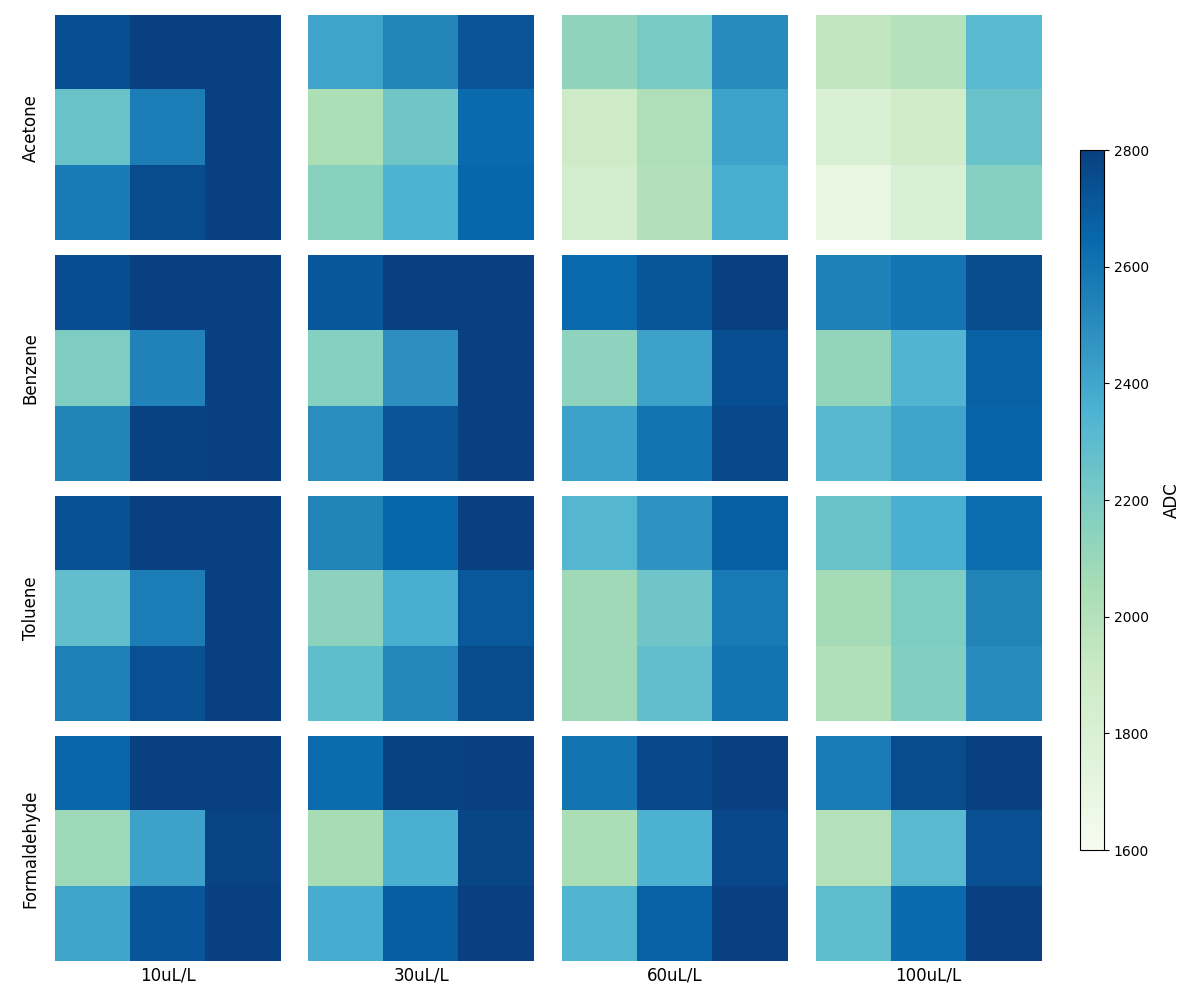

In [163]:

plt.close('all')

fig, ax = plt.subplots(
    ncols=4,  # 8 for images + 1 for the colorbar
    nrows=key_df['yy'].max() + 1,  # Based on the unique 'yy' values
    figsize=(12, 10)  # Increase width slightly for colorbar space
)

# Iterate through rows of the DataFrame and create subplots
for index, row in key_df.iterrows():
    thisAx = ax[row['yy'], index % 4]  # Use the first 8 columns for images
    gasMat = np.reshape(
        row[[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64),
        (-1, 3)
    ).astype(int)
    im = thisAx.imshow(gasMat, cmap='GnBu', vmin=1600, vmax=2800, interpolation='nearest')

    if index % 4 == 0:
        thisAx.set_ylabel(myTest[row['yy']].liquLabel, fontsize=12)
    if row['yy'] == key_df['yy'].max():
        xLab = row['conc']
        thisAx.set_xlabel(f'{xLab}uL/L', fontsize=12)

# Remove tick labels from all subplots
for rowAx in ax:
    for thisAx in rowAx:  # Skip the last column (colorbar column)
        for side in ['top','right','bottom','left']:
            thisAx.spines[side].set_visible(False)
        thisAx.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
        thisAx.set_yticklabels([])
        thisAx.set_xticklabels([])

# Use the entire 9th column for a single colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # Define the position of the colorbar
fig.colorbar(im, cax=cbar_ax, orientation='vertical')  # Add the single colorbar
cbar_ax.set_ylabel("ADC", fontsize=12, labelpad=10)  # Label for the colorbar
cbar_ax.tick_params(labelsize=10)  # Adjust tick size

# Adjust layout
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar

#### Plot Response Matrix

-0.0 1000.0


/tmp/ipykernel_6686/2331616762.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


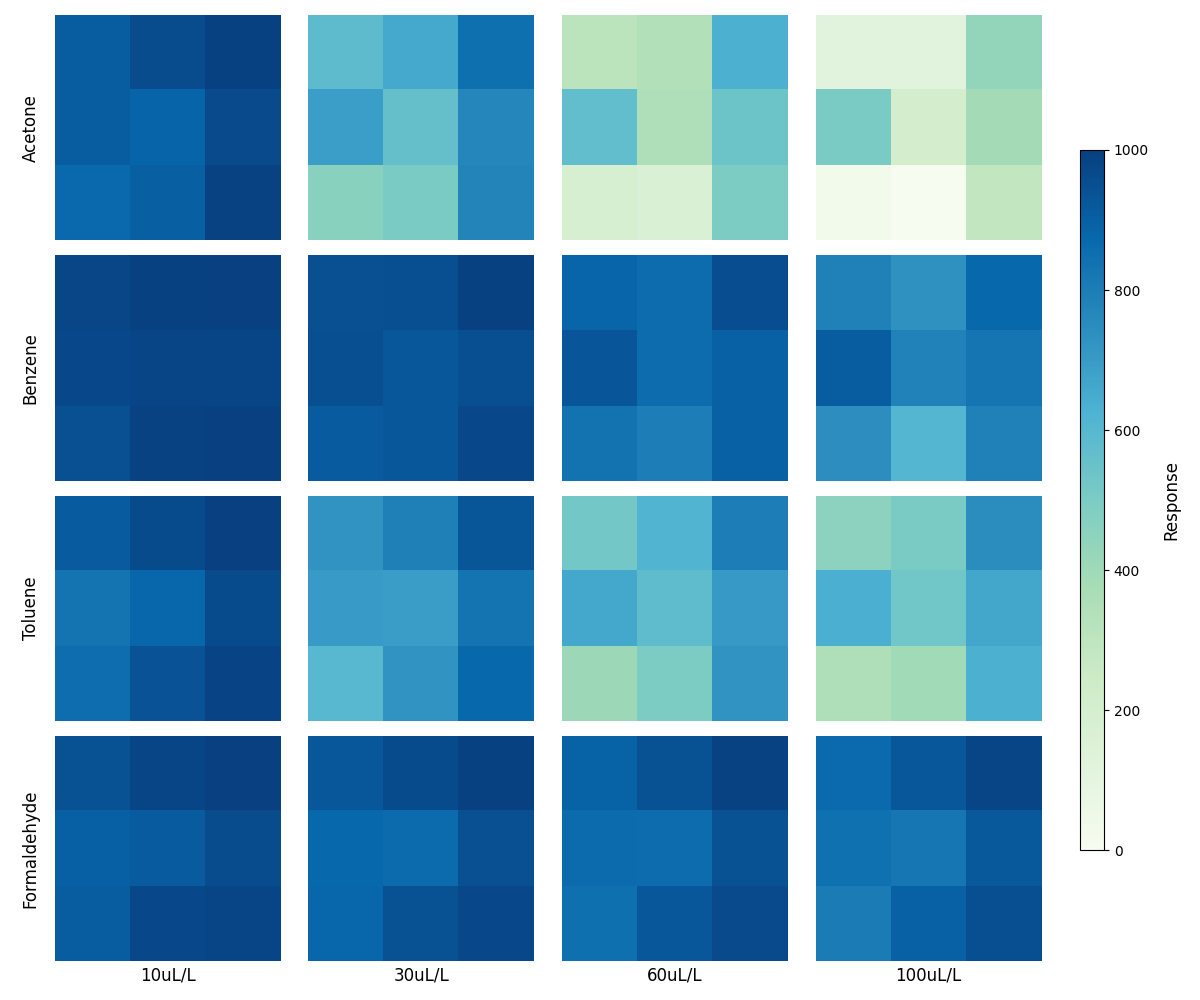

In [164]:
#Plot scale
matMin, matMax = key_df[[f'resp{i}' for i in range(0, 9)]].min().min(), key_df[[f'resp{i}' for i in range(0, 9)]].max().max()
matMin, matMax = np.round(matMin, -2), np.round(matMax, -2)
print(matMin, matMax)


plt.close('all')

fig, ax = plt.subplots(
    ncols=4,  # 8 for images + 1 for the colorbar
    nrows=key_df['yy'].max() + 1,  # Based on the unique 'yy' values
    figsize=(12, 10)  # Increase width slightly for colorbar space
)

# Iterate through rows of the DataFrame and create subplots
for index, row in key_df.iterrows():
    thisAx = ax[row['yy'], index % 4]  # Use the first 8 columns for images
    gasMat = matMax-np.reshape(
        row[[f'resp{i}' for i in range(0, 9)]].to_numpy().astype(np.int64),
        (-1, 3)
    ).astype(int)
    im = thisAx.imshow(gasMat, cmap='GnBu', vmin=matMin, vmax=matMax, interpolation='nearest')

    if index % 4 == 0:
        thisAx.set_ylabel(myTest[row['yy']].liquLabel, fontsize=12)
    if row['yy'] == key_df['yy'].max():
        xLab = row['conc']
        thisAx.set_xlabel(f'{xLab}uL/L', fontsize=12)

# Remove tick labels from all subplots
for rowAx in ax:
    for thisAx in rowAx:  # Skip the last column (colorbar column)
        for side in ['top','right','bottom','left']:
            thisAx.spines[side].set_visible(False)
        thisAx.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
        thisAx.set_yticklabels([])
        thisAx.set_xticklabels([])

# Use the entire 9th column for a single colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # Define the position of the colorbar
fig.colorbar(im, cax=cbar_ax, orientation='vertical')  # Add the single colorbar
cbar_ax.set_ylabel("Response", fontsize=12, labelpad=10)  # Label for the colorbar
cbar_ax.tick_params(labelsize=10)  # Adjust tick size

# Adjust layout
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar

### PCA

In [197]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

color_dict = {
    0: color_array[1],
    1: color_array[2],
    2: color_array[3],
    3: color_array[4],
    4: color_array[5],
    5: color_array[6],
}


In [226]:
pcaDim = [2, 3]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(key_df[[f'px{i}' for i in range(1, 9)]])
#X_scaled = scaler.fit_transform(key_df[[f'resp{i}' for i in range(1, 9)]])
pca = []
pca_df = []
for dimension in pcaDim:
    # print([f'PC{i+1}' for i in range(dimension)])
    pca.append(PCA(n_components=dimension))  # Reduce to 2 principal components
    X_pca = pca[-1].fit_transform(X_scaled)
    pca_df.append(pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(dimension)]))
    # pca_df['label'] = key_df[[f'Pump{i}' for i in range(1, 6)]]*3
    # Split the data into training and testing sets
    pca_df[-1]['yy'] = key_df['yy']
    pca_df[-1]['conc'] = key_df['conc']
# pca_df

In [211]:
pca_df

[         PC1       PC2  yy  conc
 0   2.066104  0.404945   0    10
 1  -0.587030  0.052395   0    30
 2  -3.592175 -0.053190   0    60
 3  -6.580792 -0.044180   0   100
 4   3.056857  0.819056   0    10
 5  -1.124153 -0.164245   0    30
 6  -4.914039 -0.145196   0    60
 7  -7.554021  0.085884   0   100
 8   2.345978 -0.248278   1    10
 9   1.920424 -0.312253   1    30
 10  1.137057 -0.093015   1    60
 11 -0.023759  0.128580   1   100
 12  2.827055  0.176252   1    10
 13  2.325705  0.107863   1    30
 14  1.288520  0.197687   1    60
 15 -0.069578  0.520092   1   100
 16  2.465345  0.208677   2    10
 17 -0.389855 -0.337813   2    30
 18 -2.478803 -0.047564   2    60
 19 -3.858867  0.374507   2   100
 20  3.076621  1.052162   2    10
 21  0.625220  0.308368   2    30
 22 -1.575414  0.512431   2    60
 23 -2.552722  0.712735   2   100
 24  2.728094  0.568620   3    10
 25  2.062607  0.036397   3    30
 26  1.567790 -0.334139   3    60
 27  0.753606 -0.801257   3   100
 28  1.766575 

##### Plot

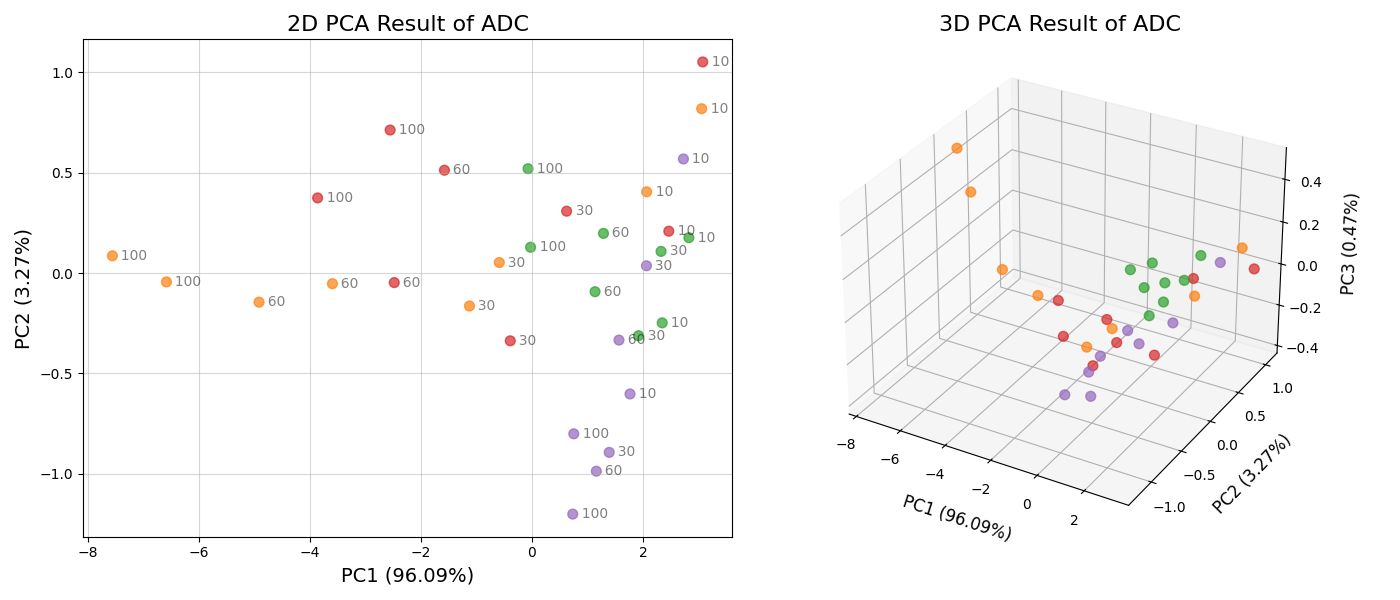

In [240]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plots

pltTitle = 'PCA Result of ADC'
#pltTitle = 'PCA Result of Response'
# Create the figure
fig = plt.figure(figsize=(14, 6))

# ------------------ 1st Plot: 2D PCA ------------------
thisAx = fig.add_subplot(1, 2, 1)  # Add the first subplot (2D)
scatter_2d = thisAx.scatter(
    pca_df[0]['PC1'],     # X-axis
    pca_df[0]['PC2'],     # Y-axis
    c=pca_df[0]['yy'].map(color_dict),  # Map 'yy' to colors using the color_dict
    s=50,                 # Size of points
    alpha=0.7             # Transparency
)
for index, row in pca_df[0].iterrows():
    thisConc = row.conc.astype(int)
    thisAx.text(row['PC1'], row['PC2'], f'  {thisConc}', alpha=0.5, va='center')
thisAx.set_title("2D "+pltTitle, fontsize=16)
thisAx.set_xlabel(f"PC1 ({pca[0].explained_variance_ratio_[0]*100:.2f}%)", fontsize=14)
thisAx.set_ylabel(f"PC2 ({pca[0].explained_variance_ratio_[1]*100:.2f}%)", fontsize=14)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)

# ------------------ 2nd Plot: 3D PCA ------------------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Add the second subplot as 3D
scatter_3d = ax2.scatter(
    pca_df[1]['PC1'],     # X-axis
    pca_df[1]['PC2'],     # Y-axis
    pca_df[1]['PC3'],     # Z-axis
    c=pca_df[1]['yy'].map(color_dict),  # Map 'yy' to colors using the color_dict
    s=50,                 # Size of points
    alpha=0.7             # Transparency
)
ax2.set_title("3D "+pltTitle, fontsize=16)
ax2.set_xlabel(f"PC1 ({pca[1].explained_variance_ratio_[0]*100:.2f}%)", fontsize=12, labelpad=10)
ax2.set_ylabel(f"PC2 ({pca[1].explained_variance_ratio_[1]*100:.2f}%)", fontsize=12, labelpad=10)
ax2.set_zlabel(f"PC3 ({pca[1].explained_variance_ratio_[2]*100:.2f}%)", fontsize=12, labelpad=10)

# ------------------ Adjust Layout ------------------
plt.tight_layout()  # Use tight layout to avoid overlap


KeyError: 'PC3'

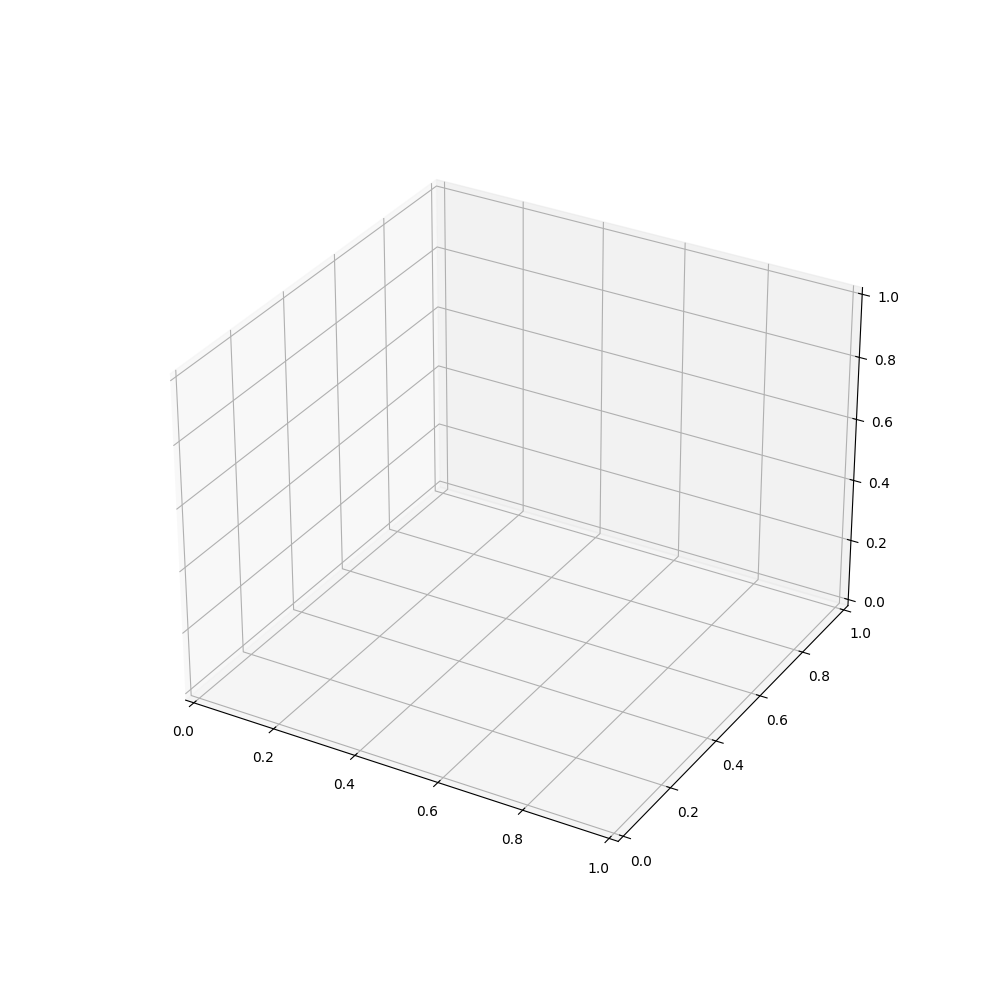

In [225]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming `pca_df` is a DataFrame with columns 'PC1', 'PC2', and 'PC3'
# And `pca` is a fitted PCA model with `explained_variance_ratio_`

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter using matplotlib
ax.scatter(
    pca_df['PC1'],  # X-axis
    pca_df['PC2'],  # Y-axis
    pca_df['PC3'],  # Z-axis
    c=pca_df['yy'].map(color_dict),       # Color of points
    s=50,           # Size of points
    alpha=0.7       # Transparency
)
for index, row in pca_df.iterrows():
    # print(row)
    # ax.text(9, 0, 0, "red", color='red')
    ax.text(row['PC1'], row['PC2'], row['PC3'], index)
# Set axis labels with explained variance ratios
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=14)
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)", fontsize=14)

# Optional: Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

### T-SNE

In [192]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Dimensions for T-SNE output
tsneDim = [2, 3]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(key_df[[f'px{i}' for i in range(1, 9)]])

# Initialize lists for T-SNE models and results
tsne = []
tsne_df = []

# Perform T-SNE for each target dimension
for dimension in tsneDim:
    tsne.append(TSNE(
        n_components=dimension,                # 2D visualization
        # perplexity=5,                 # Try different values (e.g., 5, 10, 30, 50)
        # learning_rate=500,             # Adjust learning rate (e.g., 10, 200, 500)
        n_iter=1000,                   # Increase iterations for convergence
        init='pca',                    # PCA initialization for better starting points
        # metric='euclidean',            # Use the default or try 'cosine'
        # random_state=42                # Ensure reproducibility
    ))  # T-SNE for 2D or 3D
    X_tsne = tsne[-1].fit_transform(X_scaled)  # Fit and transform the data
    tsne_df.append(pd.DataFrame(data=X_tsne, columns=[f'Dim{i+1}' for i in range(dimension)]))
    
    # Add additional columns for classification and metadata
    tsne_df[-1]['yy'] = key_df['yy']
    tsne_df[-1]['conc'] = key_df['conc']

# tsne_df now contains the 2D and 3D T-SNE results

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


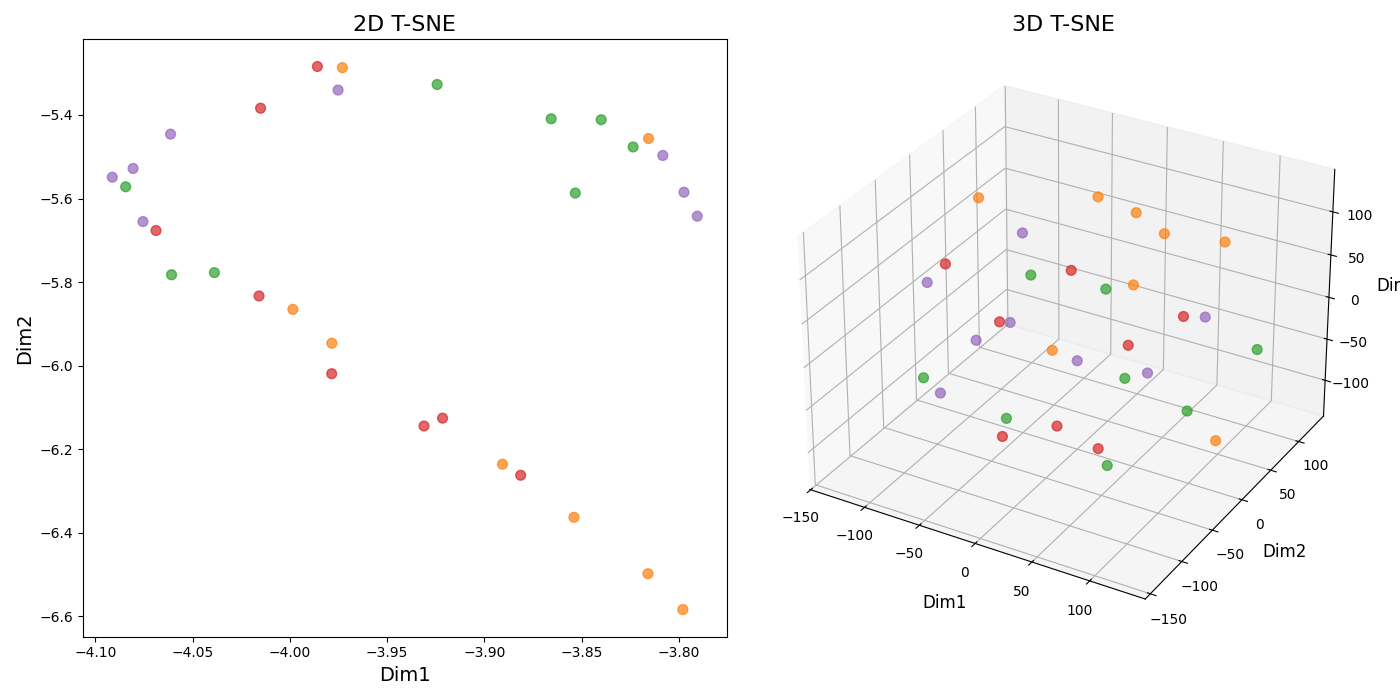

In [193]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plots

# Create the figure
fig = plt.figure(figsize=(14, 7))

# ------------------ 1st Plot: 2D T-SNE ------------------
ax1 = fig.add_subplot(1, 2, 1)  # Add the first subplot (2D)
scatter_2d = ax1.scatter(
    tsne_df[0]['Dim1'],     # X-axis (T-SNE Dim1)
    tsne_df[0]['Dim2'],     # Y-axis (T-SNE Dim2)
    c=tsne_df[0]['yy'].map(color_dict),  # Map 'yy' to colors using the color_dict
    s=50,                   # Size of points
    alpha=0.7               # Transparency
)
ax1.set_title("2D T-SNE", fontsize=16)
ax1.set_xlabel("Dim1", fontsize=14)
ax1.set_ylabel("Dim2", fontsize=14)

# ------------------ 2nd Plot: 3D T-SNE ------------------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Add the second subplot as 3D
scatter_3d = ax2.scatter(
    tsne_df[1]['Dim1'],     # X-axis (T-SNE Dim1)
    tsne_df[1]['Dim2'],     # Y-axis (T-SNE Dim2)
    tsne_df[1]['Dim3'],     # Z-axis (T-SNE Dim3)
    c=tsne_df[1]['yy'].map(color_dict),  # Map 'yy' to colors using the color_dict
    s=50,                   # Size of points
    alpha=0.7               # Transparency
)
ax2.set_title("3D T-SNE", fontsize=16)
ax2.set_xlabel("Dim1", fontsize=12, labelpad=10)
ax2.set_ylabel("Dim2", fontsize=12, labelpad=10)
ax2.set_zlabel("Dim3", fontsize=12, labelpad=10)

# ------------------ Adjust Layout ------------------
plt.tight_layout()  # Use tight layout to avoid overlap

# Show the figure
plt.show()

## Sandbox

### FFT noise analysis

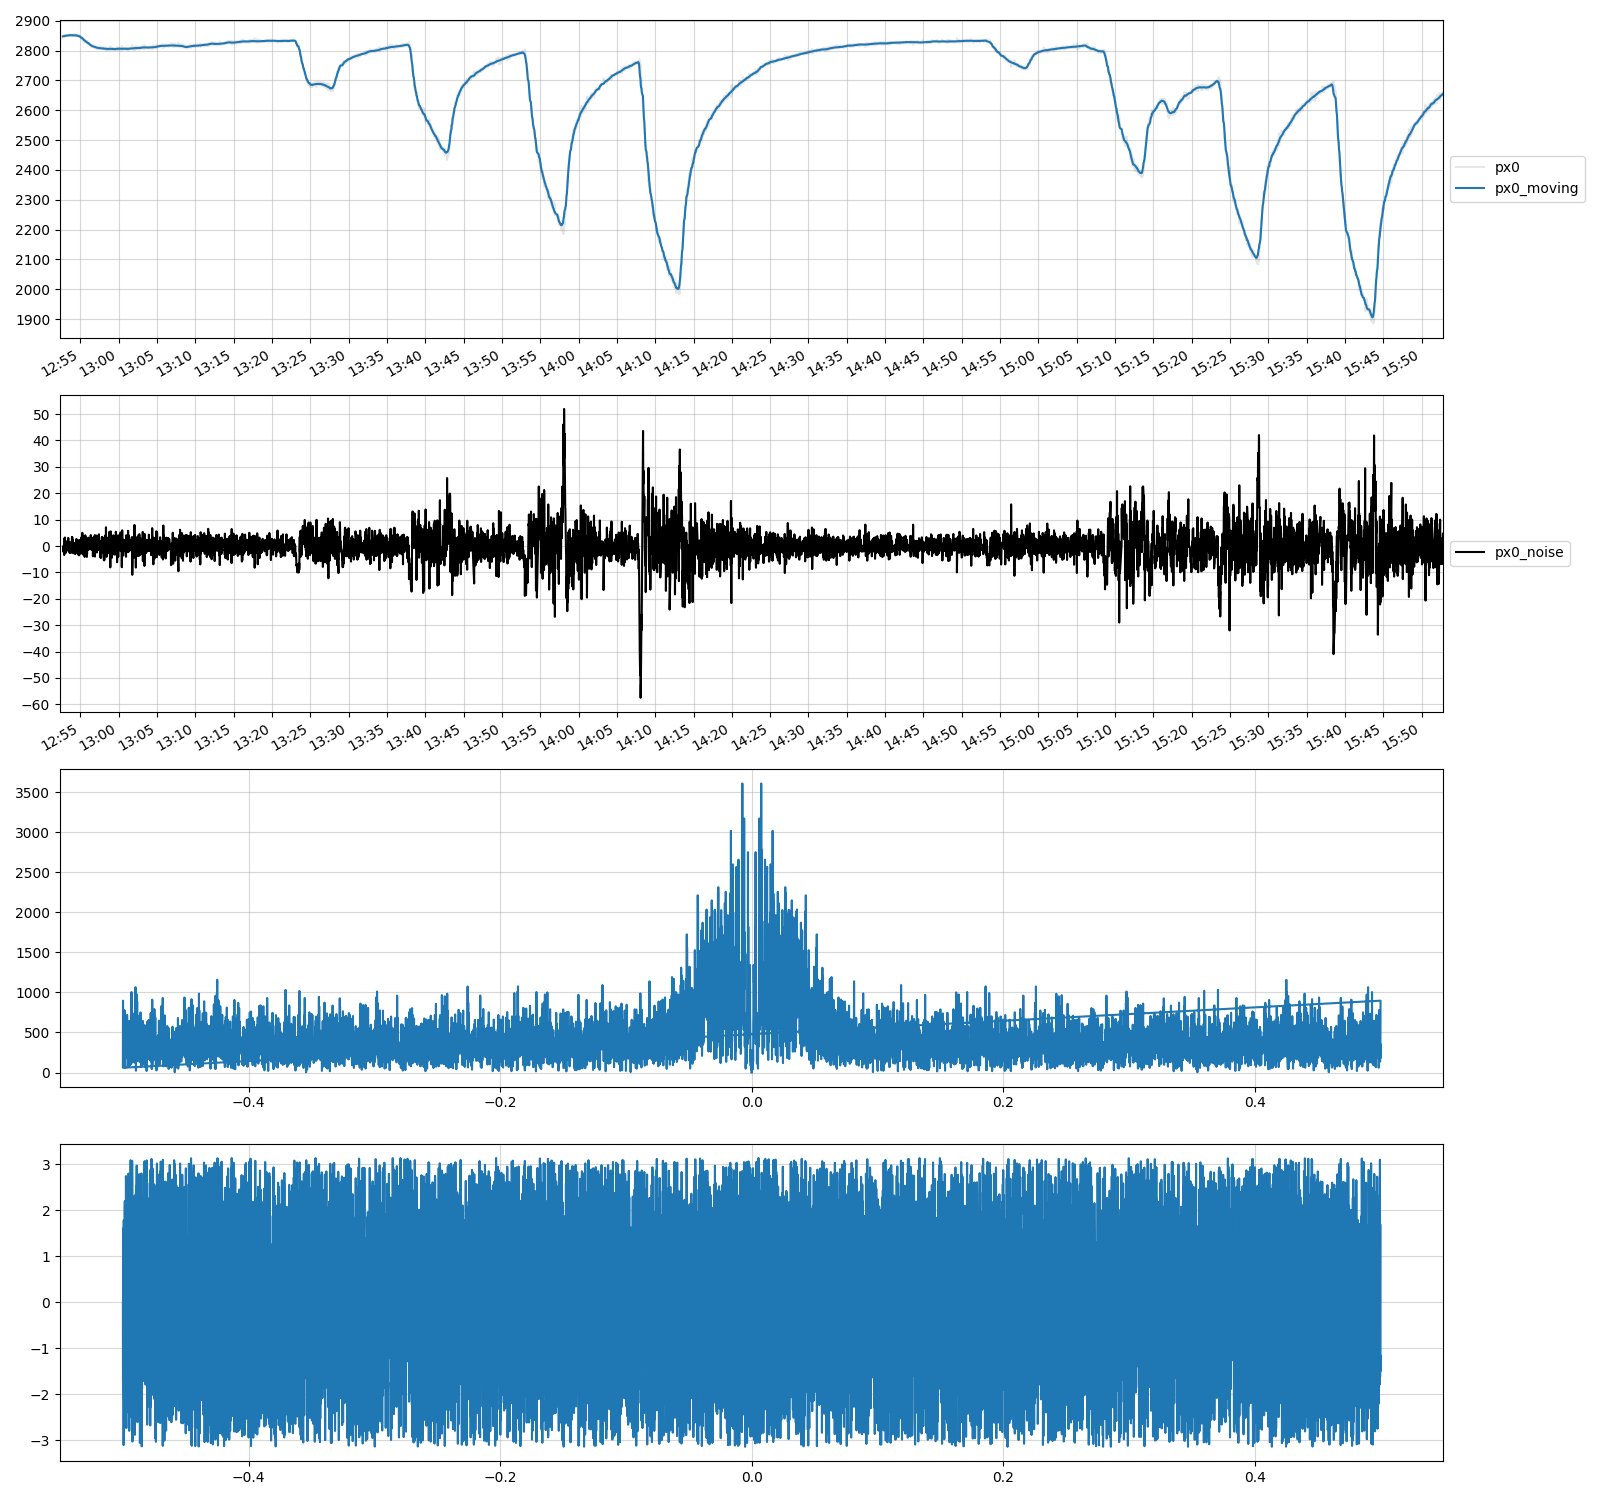

In [26]:
thisTestId = 0
pxId = 0
maWinSiz = 31
myTest[thisTestId].df[f'px{pxId}_moving'] = myTest[thisTestId].df[f'px{pxId}'].rolling(maWinSiz).mean().shift(-int(maWinSiz/2))
myTest[thisTestId].df[f'px{pxId}_noise'] =  myTest[thisTestId].df[f'px{pxId}_moving'] - myTest[thisTestId].df[f'px{pxId}']
plt.close('all')
fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(16,15))

thisAx=ax[0]
myTest[thisTestId].df.plot(ax=thisAx, y=f'px{pxId}', lw=1.5, alpha=0.1, color='black')
myTest[thisTestId].df.plot(ax=thisAx, y=f'px{pxId}_moving', lw=1.5, alpha=1)

thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.yaxis.set_major_locator(MultipleLocator(100))
thisAx.xaxis.set_major_locator(MultipleLocator(1/(12*24)))
thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
thisAx.set_xlabel('')
#thisAx.set_ylim([0, 120])
thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

thisAx=ax[1]
myTest[thisTestId].df.plot(ax=thisAx, y=f'px{pxId}_noise', lw=1.5, alpha=1, color='black')
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.yaxis.set_major_locator(MultipleLocator(10))
thisAx.xaxis.set_major_locator(MultipleLocator(1/(12*24)))
thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
thisAx.set_xlabel('')
#thisAx.set_ylim([0, 120])
thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

thisAx=ax[2]
mySing = myTest[thisTestId].df[f'px{pxId}_noise'].to_numpy()
mySing = mySing[~np.isnan(mySing)]
mySignFft = np.fft.fft(mySing)

mySignFft_amp = np.abs(mySignFft)  # Magnitude of FFT (Amplitude)
mySignFft_phase = np.angle(mySignFft)    # Phase angle of FFT (in radians)
mySignFftFreq = np.fft.fftfreq(len(mySignFft), d=1)

thisAx.plot(mySignFftFreq, mySignFft_amp)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)

thisAx=ax[3]
thisAx.plot(mySignFftFreq, mySignFft_phase)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)

fig.tight_layout()


In [21]:
myTest[thisTestId].df[f'px{pxId}_noise'].to_numpy()[:sing_df["convolved"].size]

array([        nan,         nan,         nan, ...,  3.        ,
       -4.        ,  0.06451613])

np.float64(2846.3333333333335)

### Create clean signal

In [84]:
import scipy; print(scipy.__version__)

1.15.3


In [20]:
sing_df["convolved"].size

5402

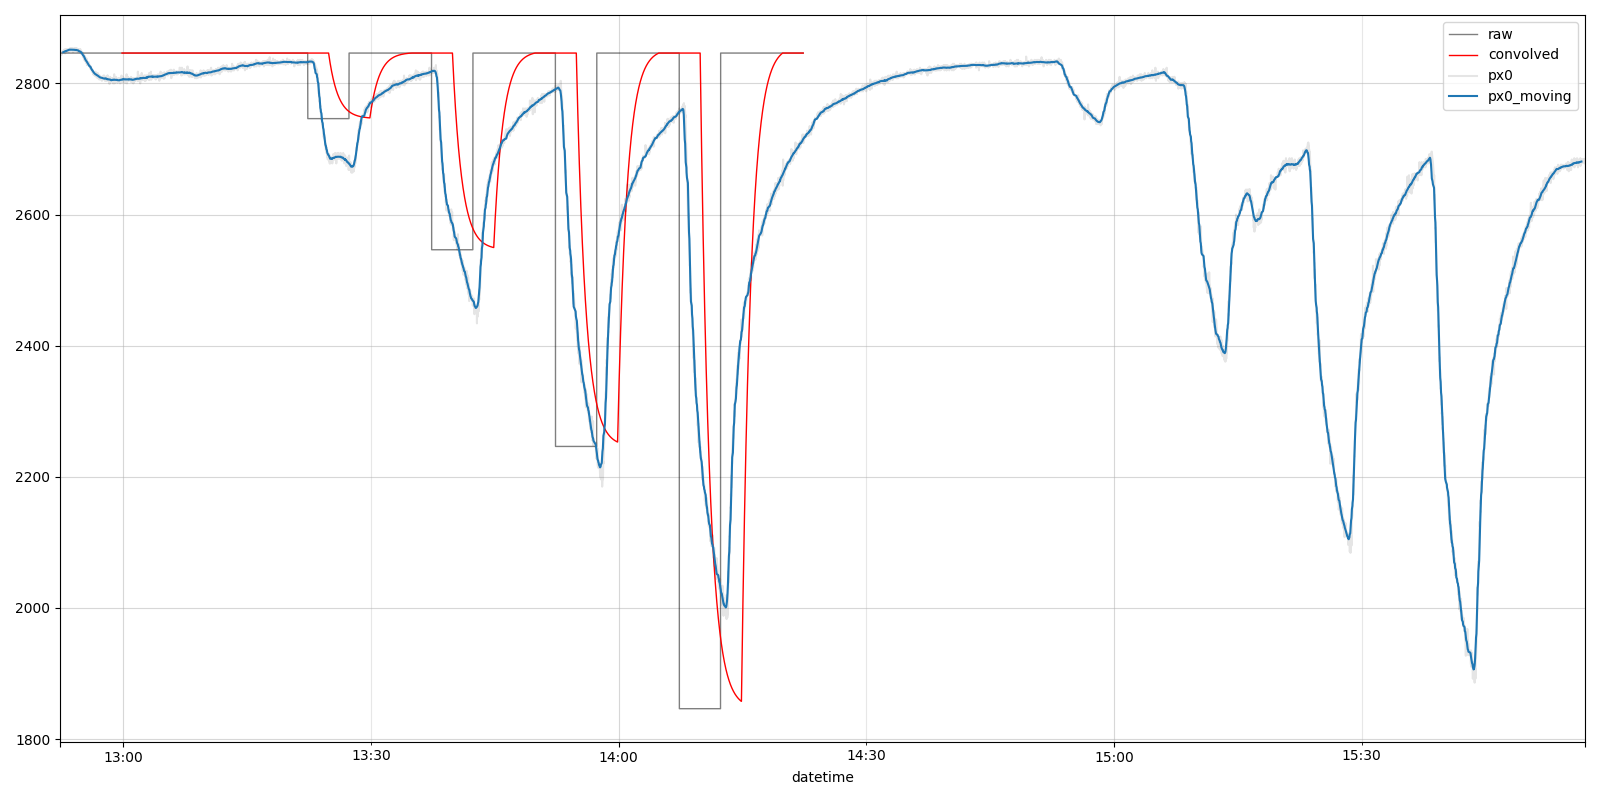

In [59]:
from scipy import integrate

rawVec = [0, 0, 0.1, 0, 0.3, 0, 0.6, 0, 1, 0]
rawVec = [item for item in rawVec for _ in range(2)]
rawVec = rawVec[1:]+[0]
tVec = [0, 30] + [5, 10]*4

cumu_tVec = []
cumu = 0
for num in tVec:
    cumu+=num*60
    cumu_tVec.append(cumu)
    cumu_tVec.append(cumu+1)

sing_df = pd.DataFrame({
    'time': cumu_tVec,
    'raw': rawVec
})
# sing_df['time'] = pd.Timestamp("2025-06-01") + pd.to_timedelta(sing_df['time'], unit='s')
sing_df['time'] = myTest[thisTestId].df.index[0] + pd.to_timedelta(sing_df['time'], unit='s')
sing_df.set_index('time', inplace=True)
sing_df = sing_df.resample('1s').interpolate(method='linear')
sing_df['raw'] = sing_df['raw']*-1000+myTest[thisTestId].df[f'px{pxId}'].iloc[0:9].mean()
sing_df['raw_diff']=sing_df['raw'].diff()
sing_df.loc[sing_df['raw_diff'] < 0, 'raw_diff'] = 0
sing_df['seconds'] = (sing_df.index - sing_df.index[0]).total_seconds()

# integral = integrate.trapezoid(y=sing_df["raw"], x=sing_df["seconds"])

kernelSize = 300 
decayRate = 0.015
kernel = 1-np.exp(-decayRate * np.arange(kernelSize))
kernel = np.concatenate([kernel, np.max(kernel)-kernel])
sing_df["convolved"] = np.convolve(sing_df["raw_diff"], kernel, mode="same")
sing_df["convolved"] = -sing_df["convolved"]+myTest[thisTestId].df[f'px{pxId}'].iloc[0:9].mean()
sing_df["convolved"] =sing_df["convolved"].shift(int(kernelSize/2))
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,8))
thisAx = ax
sing_df.plot(ax = thisAx,y= f'raw', lw=1, alpha=0.5, color='black')
sing_df.plot(ax = thisAx,y= f'convolved', lw=1, alpha=1, color='red')
myTest[thisTestId].df.plot(ax=thisAx, y=f'px{pxId}', lw=1.5, alpha=0.1, color='black')
myTest[thisTestId].df.plot(ax=thisAx, y=f'px{pxId}_moving', lw=1.5, alpha=1)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)

fig.tight_layout()

In [ ]:
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,8))
thisAx = ax
sing_df.plot(ax = thisAx,y= f'raw', lw=1, alpha=0.5, color='black')
sing_df.plot(ax = thisAx,y= f'convolved', lw=1, alpha=1, color='red')
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)

fig.tight_layout()

In [107]:
sing_df["convolved"]

time
2025-06-01 00:00:00    NaN
2025-06-01 00:00:01    NaN
2025-06-01 00:00:02    NaN
2025-06-01 00:00:03    NaN
2025-06-01 00:00:04    NaN
                      ... 
2025-06-01 01:29:57    0.0
2025-06-01 01:29:58    0.0
2025-06-01 01:29:59    0.0
2025-06-01 01:30:00    0.0
2025-06-01 01:30:01    0.0
Freq: s, Name: convolved, Length: 5402, dtype: float64

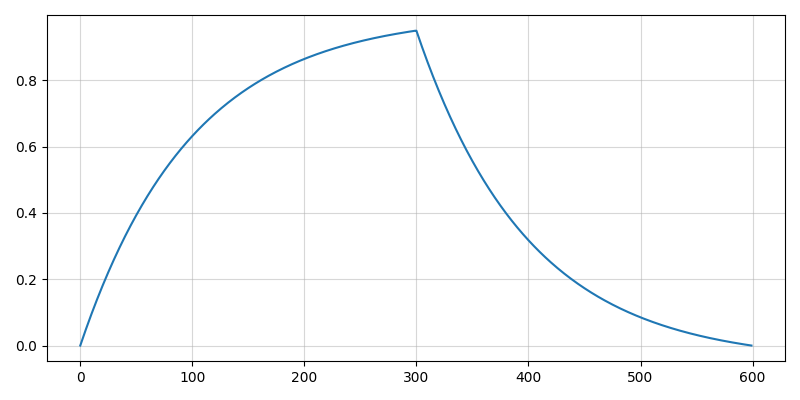

In [157]:
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,4))
thisAx = ax
thisAx.plot(kernel)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
fig.tight_layout()

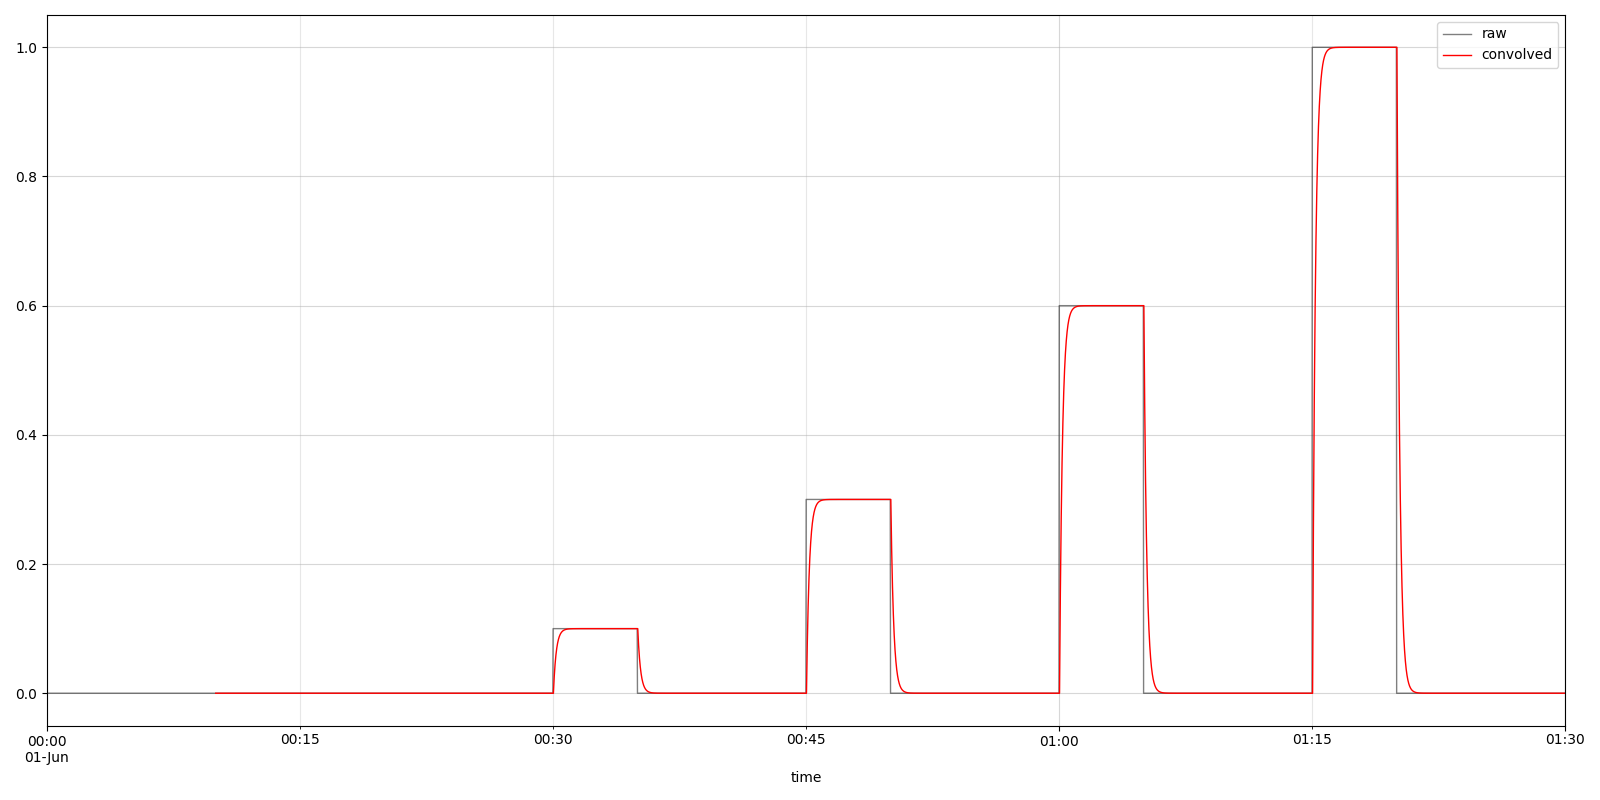

In [147]:
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,8))
thisAx = ax
sing_df.plot(ax = thisAx,y= f'raw', lw=1, alpha=0.5, color='black')
sing_df.plot(ax = thisAx,y= f'convolved', lw=1, alpha=1, color='red')
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)

fig.tight_layout()